## 1. Import packages

In [ ]:
import glob
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
import albumentations as A

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ROOT_PATH = 'dataset/lgg-mri-segmentation/kaggle_3m/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/content/drive/MyDrive/NN_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
# %cd $FOLDERNAME/cs682/datasets/
# !bash get_datasets.sh
%cd $FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NN_project


## 2. Explore Data

### Creating DataFrame

In [ ]:
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

In [ ]:
# def my_diagnosis(path):
#   s = []
#   for x in path:
#     s.append(1) if np.max(cv2.imread(x)) > 0 else s.append(0)
#   return s

  
# hi = my_diagnosis(mask_files)

# np.savetxt(fname="names.csv", delimiter=",", X=hi)

In [ ]:
# start = time.time()
hi = np.loadtxt(fname="names.csv", delimiter=",")

df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": hi})
df.head()

# stop = time.time()
# print(stop-start)

image_path  ... diagnosis
0  dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT...  ...       0.0
1  dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT...  ...       0.0
2  dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT...  ...       0.0
3  dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT...  ...       0.0
4  dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT...  ...       0.0

[5 rows x 3 columns]

In [ ]:
# def diagnosis(mask_path):
#     return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

# start = time.time()


# df = pd.DataFrame({"image_path": image_files,
#                   "mask_path": mask_files,
#                   "diagnosis": [diagnosis(x) for x in mask_files]})
# df.head()

# stop = time.time()
# print(stop-start)

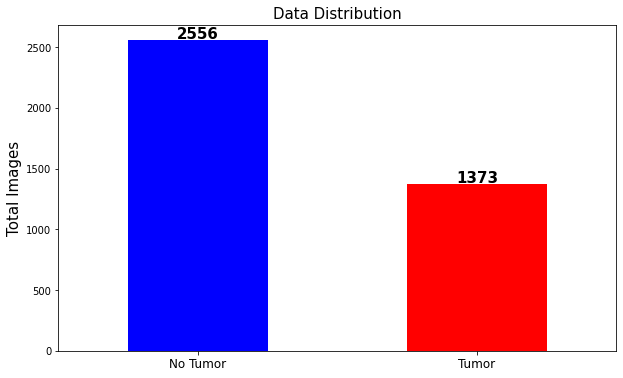

In [ ]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

### Split data into `train`/`validation`/`test` set

In [ ]:
train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15)
train_df = train_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


### Visualize Image with Mask

(-0.5, 2604.5, 520.5, -0.5)

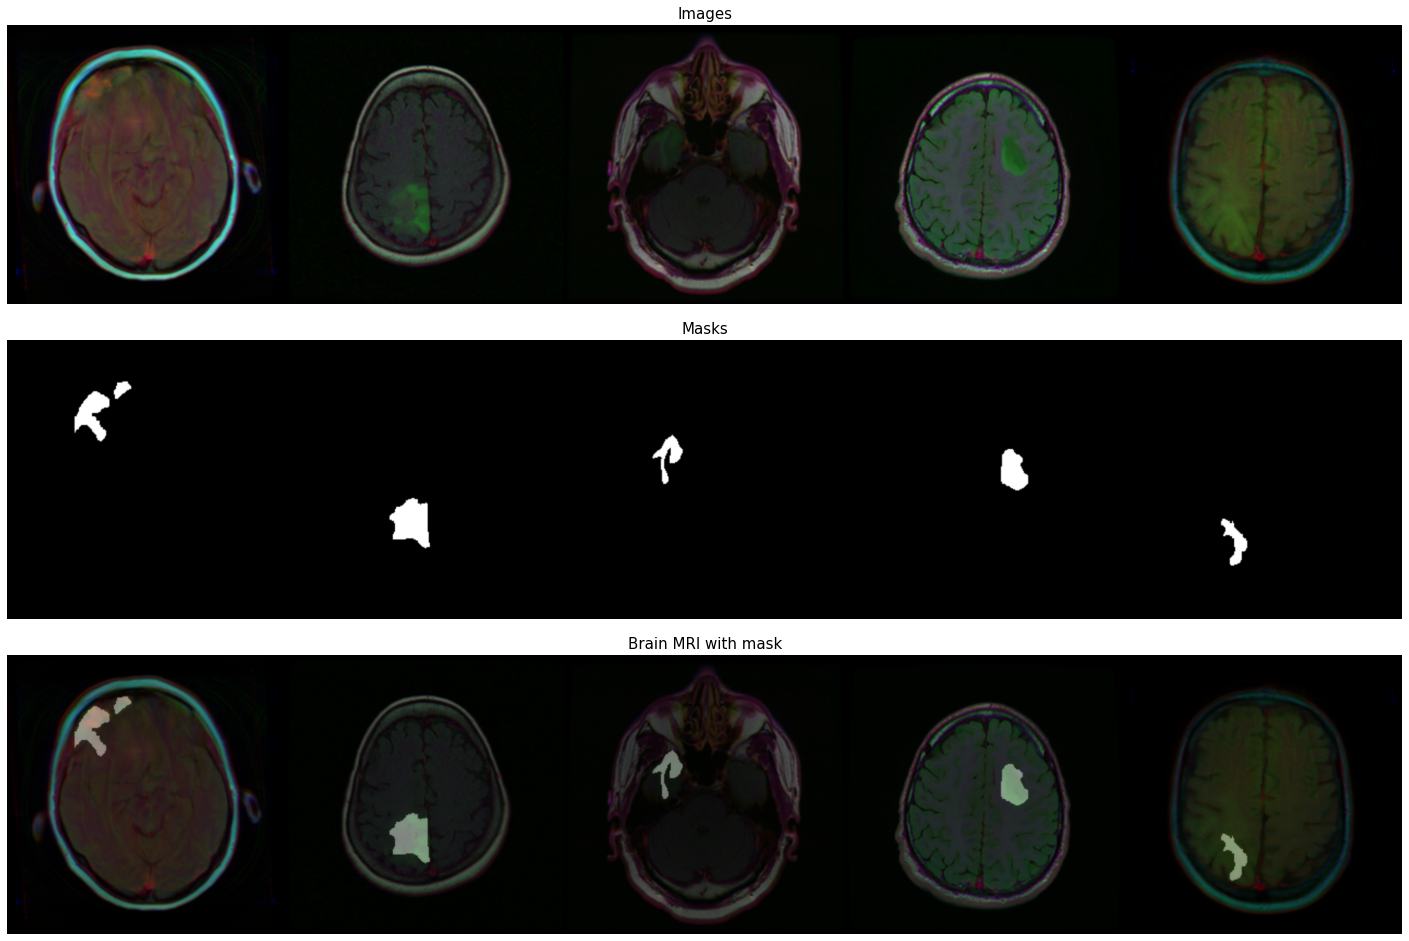

In [ ]:
IMG_SIZE = 521
images = []
masks = []
df_positive = df[df['diagnosis']==1].sample(5).values
for data in df_positive:
    img = cv2.resize(cv2.imread(data[0]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(25,25))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

## 3. Data Generator and Augmentation

In [ ]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i = 0
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img * std + mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img); 
        plt.axis('off')
        i += 1
    return plt.show()

In [ ]:
class BrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.
        diagnosis = self.df.iloc[idx,2]

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            
        image = image.transpose((2,0,1))  
        image = torch.from_numpy(image).type(torch.float32)
        image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask, diagnosis
    
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])
val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])
test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

### Create dataset

In [ ]:
train_dataset = BrainDataset(train_df, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=26, shuffle=True, num_workers=2)

val_dataset = BrainDataset(val_df, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=26, shuffle=True, num_workers=2)

test_dataset = BrainDataset(test_df, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=26, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([26, 3, 128, 128])
torch.Size([26, 1, 128, 128])
torch.Size([26])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

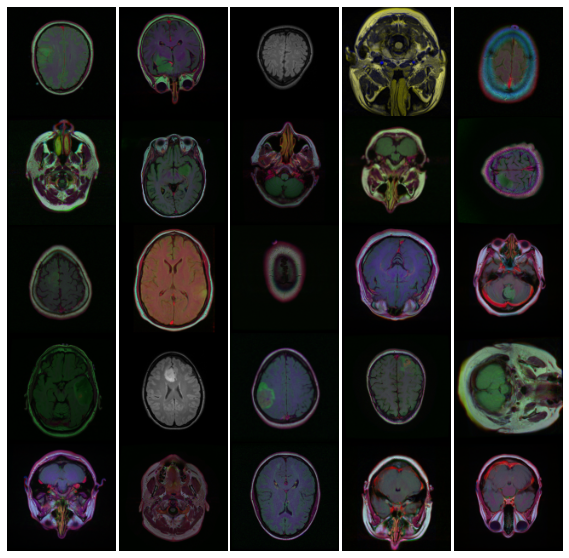

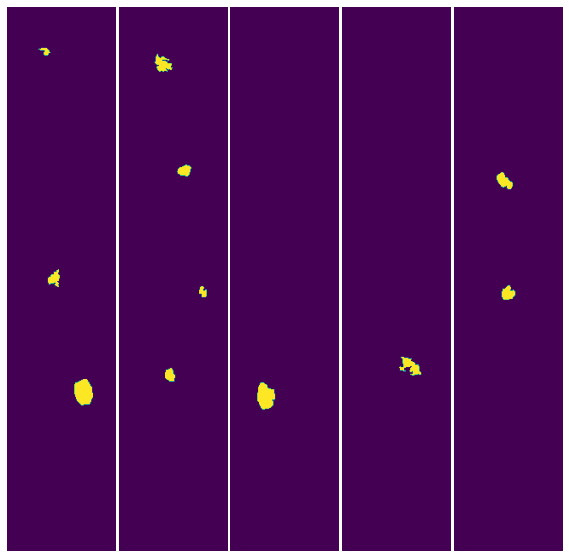

tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


In [ ]:
images, masks, diagnosis= next(iter(train_dataloader))
print(images.shape)
print(masks.shape)
print(diagnosis.shape)
show_aug(images)
show_aug(masks, image=False)
print(diagnosis)

## 4. Create Model

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)  #128,128
        self.down1 = Down(64, 128)  #64,64
        self.down2 = Down(128, 256) #32,32
        self.down3 = Down(256, 512) #16,16
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor) #8,8

        #here we add few classification heads
        self.down5 = Down(1024//factor,2048//factor) #4,4
        self.flat = nn.Flatten()
        self.linear = nn.Linear(4*4*(2048//factor),1024)  #subject to input image dimensions
        self.relu1 = nn.ReLU()
        self.scores = nn.Linear(1024,2)
        # self.relu2 = nn.ReLU()
        # self.soft = nn.Softmax()

        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)        
        self.up3 = Up(256, 128//factor, bilinear)        
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        #classification head
        x_1 = self.down5(x5)
        x_2 = self.flat(x_1)
        # print(x_2.shape)
        x_3 = self.linear(x_2)
        x_4 = self.relu1(x_3)
        scores = self.scores(x_4)
        # x_6 = self.relu2(x_5)
        # soft = self.soft(x_6)
        #segmentation head
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, scores
        # return logits

In [ ]:
model = UNet(3, 1).to(device)
# out =  model(torch.randn(1, 3, 128, 128).to(device))

out, result = model(torch.randn(26, 3, 128, 128).to(device))
# changed the input from 256,256 to 128,128 works fine
print(out.shape)
print(result.shape)

torch.Size([26, 1, 128, 128])
torch.Size([26, 2])


## 5. Metric and Loss Function

In [ ]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

## 6. Train Model

In [ ]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    with torch.no_grad():
        for step, (data, target, diagnosis) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)

            outputs, scores = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            loss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += loss

    return valloss / step

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m,nn.Conv2d):
        # torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.1)
        m.bias.data.fill_(0.01)

In [ ]:
def check_accuracy_part34(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        pred_append = np.array([1])
        z_append = np.array([1])
        i = 0
        for step, (x, y,z) in enumerate(loader):
            x = x.to(device=device)#, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device) #dtype=torch.long)
            z=z.to(device=device, dtype=torch.long)
            mask, scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == z).sum()
            num_samples += preds.size(0)
            preds = preds.detach().cpu().data.numpy()
            z = z.detach().cpu().data.numpy()
            if i == 0:
              pred_append = preds
              z_append = z
              i += 1
            else:
              pred_append = np.append(pred_append,preds)
              z_append = np.append(z_append,z)

        acc = float(num_correct) / num_samples
        print('Got f1 score (%.2f)' % (f1_score(z_append,pred_append)))
        print('Got recall score (%.2f)' % recall_score(z_append,pred_append))
        print('Got precision score (%.2f)' %precision_score(z_append,pred_append))
        print('Got ROCAUC score (%.2f)' %roc_auc_score(z_append,pred_append))

        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [ ]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i, (image, mask, diagnosis) in enumerate(tqdm(train_loader)):
            image = image.to(device)
            mask = mask.to(device)
            outputs, scores = model(image)

            # print(scores)
            # print(diagnosis)

          
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            
            
            train_dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            loss = loss_func(outputs, mask)

            diagnosis = diagnosis.type(torch.LongTensor)
            diagnosis = diagnosis.to(device)

            #scores=scores.to(device)
            
            loss_c = F.cross_entropy(scores,diagnosis)
            ## I defined diagnosis above

            losses.append(loss.item())
            train_iou.append(train_dice)

            net_loss = loss_c
            
            optimizer.zero_grad()

            # loss.backward()
            # loss_c.backward()
            net_loss.backward()

            optimizer.step()

            #printing loss
            if i % 10 == 0:
                print('classification Iteration %d, loss = %.4f' % (i, loss_c.item()))
                # x_point.append(i)
                check_accuracy_part34(val_loader, model)
                print()
                
        val_mean_iou = compute_iou(model, val_loader)
        scheduler.step(val_mean_iou)
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print('Epoch : {}/{}'.format(epoch+1, num_epochs))
        print('loss: {:.3f} - dice_coef: {:.3f} - val_dice_coef: {:.3f}'.format(np.array(losses).mean(),
                                                                               np.array(train_iou).mean(),
                                                                               val_mean_iou))
    return loss_history, train_history, val_history

In [ ]:
model = model.to(device=device)
import torch.optim as optim

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
model.apply(init_weights)

# model.load_state_dict(torch.load('unet.pt'))

checkpoint = torch.load('unet_bro.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# learning_rate = 5e-3
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                      momentum=0.9, nesterov=True)


num_epochs = 50
loss_history, train_history, val_history = train_model(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)

  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 48.5602


  1%|          | 1/116 [00:06<13:13,  6.90s/it]

Got f1 score (0.77)
Got recall score (0.65)
Got precision score (0.96)
Got ROCAUC score (0.82)
Got 341 / 393 correct (86.77)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.4631


  9%|▉         | 11/116 [00:18<04:15,  2.44s/it]

Got f1 score (0.66)
Got recall score (0.61)
Got precision score (0.73)
Got ROCAUC score (0.74)
Got 309 / 393 correct (78.63)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.4419


 18%|█▊        | 21/116 [00:30<03:46,  2.38s/it]

Got f1 score (0.20)
Got recall score (0.11)
Got precision score (0.94)
Got ROCAUC score (0.55)
Got 270 / 393 correct (68.70)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.5517


 27%|██▋       | 31/116 [00:41<03:20,  2.36s/it]

Got f1 score (0.64)
Got recall score (0.64)
Got precision score (0.64)
Got ROCAUC score (0.72)
Got 294 / 393 correct (74.81)



 34%|███▍      | 40/116 [00:46<00:50,  1.50it/s]

classification Iteration 40, loss = 0.4522


 35%|███▌      | 41/116 [00:53<02:58,  2.38s/it]

Got f1 score (0.59)
Got recall score (0.52)
Got precision score (0.70)
Got ROCAUC score (0.70)
Got 296 / 393 correct (75.32)



 43%|████▎     | 50/116 [00:58<00:44,  1.50it/s]

classification Iteration 50, loss = 0.4889


 44%|████▍     | 51/116 [01:04<02:34,  2.37s/it]

Got f1 score (0.67)
Got recall score (0.66)
Got precision score (0.69)
Got ROCAUC score (0.75)
Got 305 / 393 correct (77.61)



 52%|█████▏    | 60/116 [01:09<00:37,  1.50it/s]

classification Iteration 60, loss = 0.2660


 53%|█████▎    | 61/116 [01:16<02:09,  2.36s/it]

Got f1 score (0.74)
Got recall score (0.66)
Got precision score (0.85)
Got ROCAUC score (0.80)
Got 330 / 393 correct (83.97)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.4570


 61%|██████    | 71/116 [01:27<01:46,  2.36s/it]

Got f1 score (0.79)
Got recall score (0.72)
Got precision score (0.88)
Got ROCAUC score (0.83)
Got 341 / 393 correct (86.77)



 69%|██████▉   | 80/116 [01:32<00:23,  1.51it/s]

classification Iteration 80, loss = 0.4352


 70%|██████▉   | 81/116 [01:38<01:22,  2.36s/it]

Got f1 score (0.83)
Got recall score (0.80)
Got precision score (0.87)
Got ROCAUC score (0.86)
Got 348 / 393 correct (88.55)



 78%|███████▊  | 90/116 [01:44<00:17,  1.51it/s]

classification Iteration 90, loss = 0.4455


 78%|███████▊  | 91/116 [01:50<00:58,  2.35s/it]

Got f1 score (0.82)
Got recall score (0.79)
Got precision score (0.86)
Got ROCAUC score (0.86)
Got 346 / 393 correct (88.04)



 86%|████████▌ | 100/116 [01:55<00:10,  1.50it/s]

classification Iteration 100, loss = 0.4509


 87%|████████▋ | 101/116 [02:01<00:35,  2.37s/it]

Got f1 score (0.78)
Got recall score (0.68)
Got precision score (0.92)
Got ROCAUC score (0.82)
Got 341 / 393 correct (86.77)



 95%|█████████▍| 110/116 [02:07<00:03,  1.51it/s]

classification Iteration 110, loss = 0.4261


 96%|█████████▌| 111/116 [02:13<00:11,  2.36s/it]

Got f1 score (0.77)
Got recall score (0.85)
Got precision score (0.71)
Got ROCAUC score (0.83)
Got 324 / 393 correct (82.44)



100%|██████████| 116/116 [02:15<00:00,  1.17s/it]


Epoch : 1/50
loss: 3.275 - dice_coef: 0.023 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 73.8899


  1%|          | 1/116 [00:06<12:51,  6.71s/it]

Got f1 score (0.71)
Got recall score (0.57)
Got precision score (0.94)
Got ROCAUC score (0.77)
Got 329 / 393 correct (83.72)



  9%|▊         | 10/116 [00:11<01:11,  1.49it/s]

classification Iteration 10, loss = 0.3869


  9%|▉         | 11/116 [00:18<04:12,  2.41s/it]

Got f1 score (0.68)
Got recall score (0.57)
Got precision score (0.83)
Got ROCAUC score (0.75)
Got 318 / 393 correct (80.92)



 17%|█▋        | 20/116 [00:23<01:04,  1.50it/s]

classification Iteration 20, loss = 0.6762


 18%|█▊        | 21/116 [00:29<03:45,  2.37s/it]

Got f1 score (0.70)
Got recall score (0.55)
Got precision score (0.95)
Got ROCAUC score (0.77)
Got 328 / 393 correct (83.46)



 26%|██▌       | 30/116 [00:34<00:57,  1.51it/s]

classification Iteration 30, loss = 0.3565


 27%|██▋       | 31/116 [00:41<03:21,  2.37s/it]

Got f1 score (0.78)
Got recall score (0.67)
Got precision score (0.94)
Got ROCAUC score (0.82)
Got 342 / 393 correct (87.02)



 34%|███▍      | 40/116 [00:46<00:50,  1.50it/s]

classification Iteration 40, loss = 0.2767


 35%|███▌      | 41/116 [00:52<02:57,  2.37s/it]

Got f1 score (0.83)
Got recall score (0.73)
Got precision score (0.97)
Got ROCAUC score (0.86)
Got 353 / 393 correct (89.82)



 43%|████▎     | 50/116 [00:57<00:44,  1.49it/s]

classification Iteration 50, loss = 0.3788


 44%|████▍     | 51/116 [01:04<02:34,  2.38s/it]

Got f1 score (0.79)
Got recall score (0.68)
Got precision score (0.95)
Got ROCAUC score (0.83)
Got 344 / 393 correct (87.53)



 52%|█████▏    | 60/116 [01:09<00:37,  1.50it/s]

classification Iteration 60, loss = 0.4059


 53%|█████▎    | 61/116 [01:15<02:10,  2.37s/it]

Got f1 score (0.78)
Got recall score (0.80)
Got precision score (0.76)
Got ROCAUC score (0.83)
Got 330 / 393 correct (83.97)



 60%|██████    | 70/116 [01:20<00:30,  1.50it/s]

classification Iteration 70, loss = 0.2442


 61%|██████    | 71/116 [01:27<01:47,  2.38s/it]

Got f1 score (0.80)
Got recall score (0.91)
Got precision score (0.72)
Got ROCAUC score (0.86)
Got 332 / 393 correct (84.48)



 69%|██████▉   | 80/116 [01:32<00:24,  1.50it/s]

classification Iteration 80, loss = 0.3446


 70%|██████▉   | 81/116 [01:38<01:23,  2.38s/it]

Got f1 score (0.82)
Got recall score (0.80)
Got precision score (0.84)
Got ROCAUC score (0.86)
Got 345 / 393 correct (87.79)



 78%|███████▊  | 90/116 [01:43<00:17,  1.49it/s]

classification Iteration 90, loss = 0.4178


 78%|███████▊  | 91/116 [01:50<00:59,  2.37s/it]

Got f1 score (0.83)
Got recall score (0.78)
Got precision score (0.88)
Got ROCAUC score (0.86)
Got 349 / 393 correct (88.80)



 86%|████████▌ | 100/116 [01:55<00:10,  1.50it/s]

classification Iteration 100, loss = 0.4718


 87%|████████▋ | 101/116 [02:01<00:35,  2.36s/it]

Got f1 score (0.79)
Got recall score (0.73)
Got precision score (0.86)
Got ROCAUC score (0.83)
Got 340 / 393 correct (86.51)



 95%|█████████▍| 110/116 [02:06<00:03,  1.51it/s]

classification Iteration 110, loss = 0.3022


 96%|█████████▌| 111/116 [02:13<00:11,  2.37s/it]

Got f1 score (0.85)
Got recall score (0.74)
Got precision score (0.99)
Got ROCAUC score (0.87)
Got 357 / 393 correct (90.84)



100%|██████████| 116/116 [02:15<00:00,  1.17s/it]


Epoch : 2/50
loss: 2.826 - dice_coef: 0.023 - val_dice_coef: 0.024


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 23.7885


  1%|          | 1/116 [00:06<12:58,  6.77s/it]

Got f1 score (0.79)
Got recall score (0.67)
Got precision score (0.96)
Got ROCAUC score (0.83)
Got 344 / 393 correct (87.53)



  9%|▊         | 10/116 [00:11<01:11,  1.49it/s]

classification Iteration 10, loss = 0.4298


  9%|▉         | 11/116 [00:18<04:14,  2.43s/it]

Got f1 score (0.70)
Got recall score (0.57)
Got precision score (0.91)
Got ROCAUC score (0.77)
Got 326 / 393 correct (82.95)



 17%|█▋        | 20/116 [00:23<01:03,  1.50it/s]

classification Iteration 20, loss = 0.2679


 18%|█▊        | 21/116 [00:29<03:45,  2.37s/it]

Got f1 score (0.70)
Got recall score (0.59)
Got precision score (0.86)
Got ROCAUC score (0.77)
Got 324 / 393 correct (82.44)



 26%|██▌       | 30/116 [00:34<00:57,  1.50it/s]

classification Iteration 30, loss = 0.2628


 27%|██▋       | 31/116 [00:41<03:22,  2.38s/it]

Got f1 score (0.82)
Got recall score (0.72)
Got precision score (0.94)
Got ROCAUC score (0.85)
Got 349 / 393 correct (88.80)



 34%|███▍      | 40/116 [00:46<00:50,  1.51it/s]

classification Iteration 40, loss = 0.3101


 35%|███▌      | 41/116 [00:52<02:57,  2.37s/it]

Got f1 score (0.74)
Got recall score (0.82)
Got precision score (0.67)
Got ROCAUC score (0.80)
Got 314 / 393 correct (79.90)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.3426


 44%|████▍     | 51/116 [01:04<02:34,  2.38s/it]

Got f1 score (0.68)
Got recall score (0.53)
Got precision score (0.94)
Got ROCAUC score (0.76)
Got 324 / 393 correct (82.44)



 52%|█████▏    | 60/116 [01:09<00:37,  1.50it/s]

classification Iteration 60, loss = 0.3060


 53%|█████▎    | 61/116 [01:15<02:10,  2.37s/it]

Got f1 score (0.76)
Got recall score (0.62)
Got precision score (0.97)
Got ROCAUC score (0.80)
Got 338 / 393 correct (86.01)



 60%|██████    | 70/116 [01:21<00:30,  1.51it/s]

classification Iteration 70, loss = 0.3022


 61%|██████    | 71/116 [01:27<01:46,  2.37s/it]

Got f1 score (0.80)
Got recall score (0.78)
Got precision score (0.81)
Got ROCAUC score (0.84)
Got 338 / 393 correct (86.01)



 69%|██████▉   | 80/116 [01:32<00:23,  1.50it/s]

classification Iteration 80, loss = 0.2207


 70%|██████▉   | 81/116 [01:38<01:22,  2.36s/it]

Got f1 score (0.84)
Got recall score (0.80)
Got precision score (0.87)
Got ROCAUC score (0.87)
Got 350 / 393 correct (89.06)



 78%|███████▊  | 90/116 [01:44<00:17,  1.50it/s]

classification Iteration 90, loss = 0.2522


 78%|███████▊  | 91/116 [01:50<00:59,  2.38s/it]

Got f1 score (0.83)
Got recall score (0.80)
Got precision score (0.86)
Got ROCAUC score (0.87)
Got 348 / 393 correct (88.55)



 86%|████████▌ | 100/116 [01:55<00:10,  1.50it/s]

classification Iteration 100, loss = 0.1649


 87%|████████▋ | 101/116 [02:01<00:35,  2.37s/it]

Got f1 score (0.81)
Got recall score (0.69)
Got precision score (0.97)
Got ROCAUC score (0.84)
Got 348 / 393 correct (88.55)



 95%|█████████▍| 110/116 [02:07<00:04,  1.50it/s]

classification Iteration 110, loss = 0.2966


 96%|█████████▌| 111/116 [02:13<00:11,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.77)
Got precision score (0.95)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



100%|██████████| 116/116 [02:16<00:00,  1.17s/it]


Epoch : 3/50
loss: 2.353 - dice_coef: 0.032 - val_dice_coef: 0.021


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 51.0814


  1%|          | 1/116 [00:06<13:13,  6.90s/it]

Got f1 score (0.58)
Got recall score (0.97)
Got precision score (0.41)
Got ROCAUC score (0.61)
Got 199 / 393 correct (50.64)



  9%|▊         | 10/116 [00:12<01:11,  1.49it/s]

classification Iteration 10, loss = 0.3861


  9%|▉         | 11/116 [00:18<04:12,  2.41s/it]

Got f1 score (0.65)
Got recall score (0.86)
Got precision score (0.52)
Got ROCAUC score (0.72)
Got 266 / 393 correct (67.68)



 17%|█▋        | 20/116 [00:23<01:03,  1.51it/s]

classification Iteration 20, loss = 0.9227


 18%|█▊        | 21/116 [00:29<03:46,  2.38s/it]

Got f1 score (0.44)
Got recall score (0.28)
Got precision score (1.00)
Got ROCAUC score (0.64)
Got 295 / 393 correct (75.06)



 26%|██▌       | 30/116 [00:35<00:57,  1.50it/s]

classification Iteration 30, loss = 0.6405


 27%|██▋       | 31/116 [00:41<03:21,  2.37s/it]

Got f1 score (0.57)
Got recall score (0.54)
Got precision score (0.60)
Got ROCAUC score (0.67)
Got 280 / 393 correct (71.25)



 34%|███▍      | 40/116 [00:46<00:50,  1.49it/s]

classification Iteration 40, loss = 0.5171


 35%|███▌      | 41/116 [00:52<02:59,  2.39s/it]

Got f1 score (0.65)
Got recall score (0.72)
Got precision score (0.60)
Got ROCAUC score (0.73)
Got 288 / 393 correct (73.28)



 43%|████▎     | 50/116 [00:58<00:44,  1.50it/s]

classification Iteration 50, loss = 0.4277


 44%|████▍     | 51/116 [01:04<02:34,  2.37s/it]

Got f1 score (0.53)
Got recall score (0.37)
Got precision score (0.93)
Got ROCAUC score (0.68)
Got 303 / 393 correct (77.10)



 52%|█████▏    | 60/116 [01:09<00:37,  1.49it/s]

classification Iteration 60, loss = 0.3961


 53%|█████▎    | 61/116 [01:15<02:10,  2.37s/it]

Got f1 score (0.67)
Got recall score (0.62)
Got precision score (0.73)
Got ROCAUC score (0.75)
Got 310 / 393 correct (78.88)



 60%|██████    | 70/116 [01:21<00:30,  1.51it/s]

classification Iteration 70, loss = 0.4218


 61%|██████    | 71/116 [01:27<01:46,  2.37s/it]

Got f1 score (0.70)
Got recall score (0.74)
Got precision score (0.66)
Got ROCAUC score (0.77)
Got 305 / 393 correct (77.61)



 69%|██████▉   | 80/116 [01:32<00:24,  1.50it/s]

classification Iteration 80, loss = 0.3548


 70%|██████▉   | 81/116 [01:39<01:23,  2.38s/it]

Got f1 score (0.71)
Got recall score (0.59)
Got precision score (0.90)
Got ROCAUC score (0.78)
Got 328 / 393 correct (83.46)



 78%|███████▊  | 90/116 [01:44<00:17,  1.49it/s]

classification Iteration 90, loss = 0.3131


 78%|███████▊  | 91/116 [01:50<00:59,  2.38s/it]

Got f1 score (0.72)
Got recall score (0.60)
Got precision score (0.90)
Got ROCAUC score (0.78)
Got 329 / 393 correct (83.72)



 86%|████████▌ | 100/116 [01:55<00:10,  1.51it/s]

classification Iteration 100, loss = 0.1815


 87%|████████▋ | 101/116 [02:02<00:35,  2.37s/it]

Got f1 score (0.75)
Got recall score (0.69)
Got precision score (0.82)
Got ROCAUC score (0.80)
Got 330 / 393 correct (83.97)



 95%|█████████▍| 110/116 [02:07<00:03,  1.50it/s]

classification Iteration 110, loss = 0.3902


 96%|█████████▌| 111/116 [02:13<00:11,  2.37s/it]

Got f1 score (0.83)
Got recall score (0.75)
Got precision score (0.92)
Got ROCAUC score (0.86)
Got 350 / 393 correct (89.06)



100%|██████████| 116/116 [02:16<00:00,  1.17s/it]


Epoch : 4/50
loss: 3.119 - dice_coef: 0.041 - val_dice_coef: 0.022


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 18.4802


  1%|          | 1/116 [00:06<12:56,  6.75s/it]

Got f1 score (0.79)
Got recall score (0.68)
Got precision score (0.94)
Got ROCAUC score (0.83)
Got 343 / 393 correct (87.28)



  9%|▊         | 10/116 [00:11<01:11,  1.49it/s]

classification Iteration 10, loss = 0.3172


  9%|▉         | 11/116 [00:18<04:13,  2.42s/it]

Got f1 score (0.77)
Got recall score (0.70)
Got precision score (0.86)
Got ROCAUC score (0.82)
Got 336 / 393 correct (85.50)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.1496


 18%|█▊        | 21/116 [00:29<03:46,  2.39s/it]

Got f1 score (0.64)
Got recall score (0.47)
Got precision score (1.00)
Got ROCAUC score (0.74)
Got 321 / 393 correct (81.68)



 26%|██▌       | 30/116 [00:35<00:57,  1.50it/s]

classification Iteration 30, loss = 0.2326


 27%|██▋       | 31/116 [00:41<03:22,  2.38s/it]

Got f1 score (0.80)
Got recall score (0.67)
Got precision score (0.99)
Got ROCAUC score (0.83)
Got 347 / 393 correct (88.30)



 34%|███▍      | 40/116 [00:46<00:50,  1.50it/s]

classification Iteration 40, loss = 0.2602


 35%|███▌      | 41/116 [00:52<02:57,  2.37s/it]

Got f1 score (0.80)
Got recall score (0.78)
Got precision score (0.82)
Got ROCAUC score (0.84)
Got 339 / 393 correct (86.26)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.3089


 44%|████▍     | 51/116 [01:04<02:34,  2.38s/it]

Got f1 score (0.81)
Got recall score (0.72)
Got precision score (0.94)
Got ROCAUC score (0.85)
Got 348 / 393 correct (88.55)



 52%|█████▏    | 60/116 [01:09<00:37,  1.49it/s]

classification Iteration 60, loss = 0.7796


 53%|█████▎    | 61/116 [01:16<02:11,  2.38s/it]

Got f1 score (0.78)
Got recall score (0.69)
Got precision score (0.91)
Got ROCAUC score (0.83)
Got 341 / 393 correct (86.77)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.3123


 61%|██████    | 71/116 [01:27<01:46,  2.38s/it]

Got f1 score (0.83)
Got recall score (0.75)
Got precision score (0.93)
Got ROCAUC score (0.86)
Got 351 / 393 correct (89.31)



 69%|██████▉   | 80/116 [01:32<00:24,  1.50it/s]

classification Iteration 80, loss = 0.0647


 70%|██████▉   | 81/116 [01:39<01:23,  2.38s/it]

Got f1 score (0.78)
Got recall score (0.78)
Got precision score (0.77)
Got ROCAUC score (0.83)
Got 331 / 393 correct (84.22)



 78%|███████▊  | 90/116 [01:44<00:17,  1.49it/s]

classification Iteration 90, loss = 0.2983


 78%|███████▊  | 91/116 [01:50<00:59,  2.38s/it]

Got f1 score (0.80)
Got recall score (0.78)
Got precision score (0.81)
Got ROCAUC score (0.84)
Got 338 / 393 correct (86.01)



 86%|████████▌ | 100/116 [01:55<00:10,  1.50it/s]

classification Iteration 100, loss = 0.2144


 87%|████████▋ | 101/116 [02:02<00:35,  2.37s/it]

Got f1 score (0.82)
Got recall score (0.76)
Got precision score (0.88)
Got ROCAUC score (0.85)
Got 346 / 393 correct (88.04)



 95%|█████████▍| 110/116 [02:07<00:03,  1.51it/s]

classification Iteration 110, loss = 0.2050


 96%|█████████▌| 111/116 [02:13<00:11,  2.36s/it]

Got f1 score (0.85)
Got recall score (0.77)
Got precision score (0.94)
Got ROCAUC score (0.87)
Got 355 / 393 correct (90.33)



100%|██████████| 116/116 [02:16<00:00,  1.17s/it]


Epoch : 5/50
loss: 2.094 - dice_coef: 0.040 - val_dice_coef: 0.024


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 38.5631


  1%|          | 1/116 [00:06<13:03,  6.81s/it]

Got f1 score (0.86)
Got recall score (0.84)
Got precision score (0.88)
Got ROCAUC score (0.89)
Got 355 / 393 correct (90.33)



  9%|▊         | 10/116 [00:11<01:11,  1.49it/s]

classification Iteration 10, loss = 0.2421


  9%|▉         | 11/116 [00:18<04:13,  2.41s/it]

Got f1 score (0.81)
Got recall score (0.82)
Got precision score (0.80)
Got ROCAUC score (0.86)
Got 340 / 393 correct (86.51)



 17%|█▋        | 20/116 [00:23<01:03,  1.50it/s]

classification Iteration 20, loss = 0.3581


 18%|█▊        | 21/116 [00:29<03:45,  2.38s/it]

Got f1 score (0.80)
Got recall score (0.70)
Got precision score (0.94)
Got ROCAUC score (0.84)
Got 346 / 393 correct (88.04)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.6838


 27%|██▋       | 31/116 [00:41<03:22,  2.38s/it]

Got f1 score (0.79)
Got recall score (0.68)
Got precision score (0.94)
Got ROCAUC score (0.83)
Got 343 / 393 correct (87.28)



 34%|███▍      | 40/116 [00:46<00:50,  1.49it/s]

classification Iteration 40, loss = 0.3100


 35%|███▌      | 41/116 [00:52<02:57,  2.36s/it]

Got f1 score (0.79)
Got recall score (0.77)
Got precision score (0.80)
Got ROCAUC score (0.83)
Got 335 / 393 correct (85.24)



 43%|████▎     | 50/116 [00:58<00:43,  1.50it/s]

classification Iteration 50, loss = 0.3202


 44%|████▍     | 51/116 [01:04<02:34,  2.37s/it]

Got f1 score (0.78)
Got recall score (0.88)
Got precision score (0.71)
Got ROCAUC score (0.84)
Got 327 / 393 correct (83.21)



 52%|█████▏    | 60/116 [01:09<00:37,  1.50it/s]

classification Iteration 60, loss = 0.2857


 53%|█████▎    | 61/116 [01:15<02:09,  2.35s/it]

Got f1 score (0.81)
Got recall score (0.75)
Got precision score (0.87)
Got ROCAUC score (0.85)
Got 344 / 393 correct (87.53)



 60%|██████    | 70/116 [01:20<00:30,  1.50it/s]

classification Iteration 70, loss = 0.1848


 61%|██████    | 71/116 [01:27<01:47,  2.39s/it]

Got f1 score (0.83)
Got recall score (0.81)
Got precision score (0.85)
Got ROCAUC score (0.87)
Got 347 / 393 correct (88.30)



 69%|██████▉   | 80/116 [01:32<00:24,  1.50it/s]

classification Iteration 80, loss = 0.2109


 70%|██████▉   | 81/116 [01:38<01:23,  2.37s/it]

Got f1 score (0.86)
Got recall score (0.78)
Got precision score (0.95)
Got ROCAUC score (0.88)
Got 357 / 393 correct (90.84)



 78%|███████▊  | 90/116 [01:44<00:17,  1.50it/s]

classification Iteration 90, loss = 0.3494


 78%|███████▊  | 91/116 [01:50<00:59,  2.38s/it]

Got f1 score (0.86)
Got recall score (0.78)
Got precision score (0.96)
Got ROCAUC score (0.88)
Got 358 / 393 correct (91.09)



 86%|████████▌ | 100/116 [01:55<00:10,  1.50it/s]

classification Iteration 100, loss = 0.3247


 87%|████████▋ | 101/116 [02:01<00:35,  2.37s/it]

Got f1 score (0.81)
Got recall score (0.70)
Got precision score (0.96)
Got ROCAUC score (0.84)
Got 348 / 393 correct (88.55)



 95%|█████████▍| 110/116 [02:07<00:03,  1.51it/s]

classification Iteration 110, loss = 0.3005


 96%|█████████▌| 111/116 [02:13<00:11,  2.38s/it]

Got f1 score (0.83)
Got recall score (0.76)
Got precision score (0.90)
Got ROCAUC score (0.86)
Got 349 / 393 correct (88.80)



100%|██████████| 116/116 [02:16<00:00,  1.17s/it]


Epoch : 6/50
loss: 2.007 - dice_coef: 0.032 - val_dice_coef: 0.023


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 7.8643


  1%|          | 1/116 [00:06<12:57,  6.76s/it]

Got f1 score (0.82)
Got recall score (0.71)
Got precision score (0.96)
Got ROCAUC score (0.85)
Got 349 / 393 correct (88.80)



  9%|▊         | 10/116 [00:11<01:11,  1.49it/s]

classification Iteration 10, loss = 0.2168


  9%|▉         | 11/116 [00:18<04:13,  2.41s/it]

Got f1 score (0.84)
Got recall score (0.77)
Got precision score (0.94)
Got ROCAUC score (0.87)
Got 354 / 393 correct (90.08)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.3084


 18%|█▊        | 21/116 [00:29<03:46,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.77)
Got precision score (0.94)
Got ROCAUC score (0.87)
Got 355 / 393 correct (90.33)



 26%|██▌       | 30/116 [00:35<00:57,  1.50it/s]

classification Iteration 30, loss = 0.1555


 27%|██▋       | 31/116 [00:41<03:21,  2.37s/it]

Got f1 score (0.84)
Got recall score (0.75)
Got precision score (0.95)
Got ROCAUC score (0.87)
Got 354 / 393 correct (90.08)



 34%|███▍      | 40/116 [00:46<00:50,  1.50it/s]

classification Iteration 40, loss = 0.1370


 35%|███▌      | 41/116 [00:52<02:58,  2.38s/it]

Got f1 score (0.84)
Got recall score (0.77)
Got precision score (0.92)
Got ROCAUC score (0.87)
Got 353 / 393 correct (89.82)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.2159


 44%|████▍     | 51/116 [01:04<02:34,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.81)
Got precision score (0.90)
Got ROCAUC score (0.88)
Got 354 / 393 correct (90.08)



 52%|█████▏    | 60/116 [01:09<00:37,  1.51it/s]

classification Iteration 60, loss = 0.3237


 53%|█████▎    | 61/116 [01:15<02:10,  2.37s/it]

Got f1 score (0.84)
Got recall score (0.81)
Got precision score (0.88)
Got ROCAUC score (0.88)
Got 352 / 393 correct (89.57)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.2283


 61%|██████    | 71/116 [01:27<01:46,  2.37s/it]

Got f1 score (0.86)
Got recall score (0.80)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



 69%|██████▉   | 80/116 [01:32<00:24,  1.50it/s]

classification Iteration 80, loss = 0.1641


 70%|██████▉   | 81/116 [01:38<01:22,  2.37s/it]

Got f1 score (0.86)
Got recall score (0.80)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



 78%|███████▊  | 90/116 [01:44<00:17,  1.51it/s]

classification Iteration 90, loss = 0.1839


 78%|███████▊  | 91/116 [01:50<00:59,  2.37s/it]

Got f1 score (0.86)
Got recall score (0.83)
Got precision score (0.90)
Got ROCAUC score (0.89)
Got 357 / 393 correct (90.84)



 86%|████████▌ | 100/116 [01:55<00:10,  1.50it/s]

classification Iteration 100, loss = 0.1524


 87%|████████▋ | 101/116 [02:02<00:35,  2.38s/it]

Got f1 score (0.87)
Got recall score (0.85)
Got precision score (0.90)
Got ROCAUC score (0.90)
Got 359 / 393 correct (91.35)



 95%|█████████▍| 110/116 [02:07<00:04,  1.49it/s]

classification Iteration 110, loss = 0.2198


 96%|█████████▌| 111/116 [02:13<00:11,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.80)
Got precision score (0.91)
Got ROCAUC score (0.88)
Got 354 / 393 correct (90.08)



100%|██████████| 116/116 [02:16<00:00,  1.17s/it]


Epoch : 7/50
loss: 1.920 - dice_coef: 0.030 - val_dice_coef: 0.026


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 6.3873


  1%|          | 1/116 [00:06<13:06,  6.83s/it]

Got f1 score (0.69)
Got recall score (0.54)
Got precision score (0.97)
Got ROCAUC score (0.77)
Got 328 / 393 correct (83.46)



  9%|▊         | 10/116 [00:11<01:11,  1.49it/s]

classification Iteration 10, loss = 0.2062


  9%|▉         | 11/116 [00:18<04:12,  2.40s/it]

Got f1 score (0.85)
Got recall score (0.87)
Got precision score (0.83)
Got ROCAUC score (0.89)
Got 351 / 393 correct (89.31)



 17%|█▋        | 20/116 [00:23<01:03,  1.50it/s]

classification Iteration 20, loss = 0.1935


 18%|█▊        | 21/116 [00:29<03:46,  2.39s/it]

Got f1 score (0.85)
Got recall score (0.80)
Got precision score (0.91)
Got ROCAUC score (0.88)
Got 355 / 393 correct (90.33)



 26%|██▌       | 30/116 [00:35<00:57,  1.50it/s]

classification Iteration 30, loss = 0.2487


 27%|██▋       | 31/116 [00:41<03:21,  2.38s/it]

Got f1 score (0.82)
Got recall score (0.75)
Got precision score (0.91)
Got ROCAUC score (0.86)
Got 349 / 393 correct (88.80)



 34%|███▍      | 40/116 [00:46<00:50,  1.49it/s]

classification Iteration 40, loss = 0.0919


 35%|███▌      | 41/116 [00:52<02:58,  2.38s/it]

Got f1 score (0.83)
Got recall score (0.76)
Got precision score (0.92)
Got ROCAUC score (0.86)
Got 351 / 393 correct (89.31)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.2475


 44%|████▍     | 51/116 [01:04<02:34,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.80)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 355 / 393 correct (90.33)



 52%|█████▏    | 60/116 [01:09<00:37,  1.50it/s]

classification Iteration 60, loss = 0.3952


 53%|█████▎    | 61/116 [01:16<02:11,  2.39s/it]

Got f1 score (0.86)
Got recall score (0.81)
Got precision score (0.91)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



 60%|██████    | 70/116 [01:21<00:30,  1.49it/s]

classification Iteration 70, loss = 0.1727


 61%|██████    | 71/116 [01:27<01:47,  2.39s/it]

Got f1 score (0.86)
Got recall score (0.82)
Got precision score (0.90)
Got ROCAUC score (0.89)
Got 356 / 393 correct (90.59)



 69%|██████▉   | 80/116 [01:32<00:24,  1.49it/s]

classification Iteration 80, loss = 0.3260


 70%|██████▉   | 81/116 [01:39<01:23,  2.37s/it]

Got f1 score (0.86)
Got recall score (0.80)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 357 / 393 correct (90.84)



 78%|███████▊  | 90/116 [01:44<00:17,  1.50it/s]

classification Iteration 90, loss = 0.4790


 78%|███████▊  | 91/116 [01:50<00:59,  2.39s/it]

Got f1 score (0.83)
Got recall score (0.74)
Got precision score (0.94)
Got ROCAUC score (0.86)
Got 352 / 393 correct (89.57)



 86%|████████▌ | 100/116 [01:55<00:10,  1.50it/s]

classification Iteration 100, loss = 0.2027


 87%|████████▋ | 101/116 [02:02<00:35,  2.37s/it]

Got f1 score (0.86)
Got recall score (0.81)
Got precision score (0.92)
Got ROCAUC score (0.89)
Got 357 / 393 correct (90.84)



 95%|█████████▍| 110/116 [02:07<00:04,  1.49it/s]

classification Iteration 110, loss = 0.2662


 96%|█████████▌| 111/116 [02:13<00:11,  2.40s/it]

Got f1 score (0.86)
Got recall score (0.82)
Got precision score (0.91)
Got ROCAUC score (0.89)
Got 357 / 393 correct (90.84)



100%|██████████| 116/116 [02:16<00:00,  1.18s/it]


Epoch : 8/50
loss: 1.905 - dice_coef: 0.031 - val_dice_coef: 0.025


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 3.9779


  1%|          | 1/116 [00:06<13:02,  6.80s/it]

Got f1 score (0.78)
Got recall score (0.66)
Got precision score (0.95)
Got ROCAUC score (0.82)
Got 341 / 393 correct (86.77)



  9%|▊         | 10/116 [00:11<01:11,  1.49it/s]

classification Iteration 10, loss = 0.2068


  9%|▉         | 11/116 [00:18<04:16,  2.44s/it]

Got f1 score (0.83)
Got recall score (0.75)
Got precision score (0.93)
Got ROCAUC score (0.86)
Got 351 / 393 correct (89.31)



 17%|█▋        | 20/116 [00:23<01:04,  1.50it/s]

classification Iteration 20, loss = 0.1800


 18%|█▊        | 21/116 [00:29<03:44,  2.37s/it]

Got f1 score (0.86)
Got recall score (0.81)
Got precision score (0.91)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.3276


 27%|██▋       | 31/116 [00:41<03:22,  2.38s/it]

Got f1 score (0.84)
Got recall score (0.75)
Got precision score (0.94)
Got ROCAUC score (0.86)
Got 353 / 393 correct (89.82)



 34%|███▍      | 40/116 [00:46<00:50,  1.49it/s]

classification Iteration 40, loss = 0.2577


 35%|███▌      | 41/116 [00:53<02:59,  2.39s/it]

Got f1 score (0.85)
Got recall score (0.80)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 355 / 393 correct (90.33)



 43%|████▎     | 50/116 [00:58<00:43,  1.51it/s]

classification Iteration 50, loss = 0.2787


 44%|████▍     | 51/116 [01:04<02:34,  2.37s/it]

Got f1 score (0.84)
Got recall score (0.78)
Got precision score (0.91)
Got ROCAUC score (0.87)
Got 352 / 393 correct (89.57)



 52%|█████▏    | 60/116 [01:09<00:37,  1.49it/s]

classification Iteration 60, loss = 0.3678


 53%|█████▎    | 61/116 [01:16<02:09,  2.36s/it]

Got f1 score (0.85)
Got recall score (0.78)
Got precision score (0.93)
Got ROCAUC score (0.87)
Got 355 / 393 correct (90.33)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.3394


 61%|██████    | 71/116 [01:27<01:46,  2.38s/it]

Got f1 score (0.87)
Got recall score (0.84)
Got precision score (0.90)
Got ROCAUC score (0.89)
Got 358 / 393 correct (91.09)



 69%|██████▉   | 80/116 [01:32<00:24,  1.50it/s]

classification Iteration 80, loss = 0.3686


 70%|██████▉   | 81/116 [01:39<01:23,  2.38s/it]

Got f1 score (0.87)
Got recall score (0.81)
Got precision score (0.93)
Got ROCAUC score (0.89)
Got 359 / 393 correct (91.35)



 78%|███████▊  | 90/116 [01:44<00:17,  1.50it/s]

classification Iteration 90, loss = 0.3440


 78%|███████▊  | 91/116 [01:50<00:59,  2.37s/it]

Got f1 score (0.86)
Got recall score (0.80)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



 86%|████████▌ | 100/116 [01:55<00:10,  1.49it/s]

classification Iteration 100, loss = 0.2095


 87%|████████▋ | 101/116 [02:02<00:35,  2.38s/it]

Got f1 score (0.86)
Got recall score (0.81)
Got precision score (0.91)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



 95%|█████████▍| 110/116 [02:07<00:04,  1.49it/s]

classification Iteration 110, loss = 0.1135


 96%|█████████▌| 111/116 [02:13<00:11,  2.39s/it]

Got f1 score (0.86)
Got recall score (0.85)
Got precision score (0.88)
Got ROCAUC score (0.89)
Got 356 / 393 correct (90.59)



100%|██████████| 116/116 [02:16<00:00,  1.18s/it]


Epoch : 9/50
loss: 1.872 - dice_coef: 0.031 - val_dice_coef: 0.021


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 2.4703


  1%|          | 1/116 [00:06<13:06,  6.84s/it]

Got f1 score (0.75)
Got recall score (0.64)
Got precision score (0.93)
Got ROCAUC score (0.80)
Got 336 / 393 correct (85.50)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.2110


  9%|▉         | 11/116 [00:18<04:15,  2.43s/it]

Got f1 score (0.86)
Got recall score (0.79)
Got precision score (0.95)
Got ROCAUC score (0.88)
Got 358 / 393 correct (91.09)



 17%|█▋        | 20/116 [00:23<01:04,  1.50it/s]

classification Iteration 20, loss = 0.3329


 18%|█▊        | 21/116 [00:30<03:47,  2.40s/it]

Got f1 score (0.84)
Got recall score (0.74)
Got precision score (0.95)
Got ROCAUC score (0.86)
Got 353 / 393 correct (89.82)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.2043


 27%|██▋       | 31/116 [00:41<03:23,  2.39s/it]

Got f1 score (0.87)
Got recall score (0.85)
Got precision score (0.90)
Got ROCAUC score (0.90)
Got 359 / 393 correct (91.35)



 34%|███▍      | 40/116 [00:46<00:50,  1.50it/s]

classification Iteration 40, loss = 0.2626


 35%|███▌      | 41/116 [00:53<02:58,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.78)
Got precision score (0.92)
Got ROCAUC score (0.87)
Got 354 / 393 correct (90.08)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.2040


 44%|████▍     | 51/116 [01:04<02:34,  2.37s/it]

Got f1 score (0.85)
Got recall score (0.79)
Got precision score (0.92)
Got ROCAUC score (0.87)
Got 354 / 393 correct (90.08)



 52%|█████▏    | 60/116 [01:09<00:37,  1.49it/s]

classification Iteration 60, loss = 0.1731


 53%|█████▎    | 61/116 [01:16<02:11,  2.39s/it]

Got f1 score (0.85)
Got recall score (0.79)
Got precision score (0.93)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.4642


 61%|██████    | 71/116 [01:27<01:46,  2.38s/it]

Got f1 score (0.86)
Got recall score (0.80)
Got precision score (0.93)
Got ROCAUC score (0.88)
Got 357 / 393 correct (90.84)



 69%|██████▉   | 80/116 [01:32<00:24,  1.49it/s]

classification Iteration 80, loss = 0.4205


 70%|██████▉   | 81/116 [01:39<01:23,  2.38s/it]

Got f1 score (0.84)
Got recall score (0.87)
Got precision score (0.80)
Got ROCAUC score (0.88)
Got 346 / 393 correct (88.04)



 78%|███████▊  | 90/116 [01:44<00:17,  1.50it/s]

classification Iteration 90, loss = 0.1133


 78%|███████▊  | 91/116 [01:50<00:59,  2.37s/it]

Got f1 score (0.83)
Got recall score (0.75)
Got precision score (0.93)
Got ROCAUC score (0.86)
Got 351 / 393 correct (89.31)



 86%|████████▌ | 100/116 [01:56<00:10,  1.49it/s]

classification Iteration 100, loss = 0.2638


 87%|████████▋ | 101/116 [02:02<00:35,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.81)
Got precision score (0.90)
Got ROCAUC score (0.88)
Got 355 / 393 correct (90.33)



 95%|█████████▍| 110/116 [02:07<00:04,  1.50it/s]

classification Iteration 110, loss = 0.1719


 96%|█████████▌| 111/116 [02:13<00:11,  2.37s/it]

Got f1 score (0.86)
Got recall score (0.85)
Got precision score (0.87)
Got ROCAUC score (0.89)
Got 356 / 393 correct (90.59)



100%|██████████| 116/116 [02:16<00:00,  1.18s/it]


Epoch : 10/50
loss: 1.850 - dice_coef: 0.031 - val_dice_coef: 0.020


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.5776


  1%|          | 1/116 [00:06<13:02,  6.81s/it]

Got f1 score (0.76)
Got recall score (0.64)
Got precision score (0.95)
Got ROCAUC score (0.81)
Got 338 / 393 correct (86.01)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 0.3266


  9%|▉         | 11/116 [00:18<04:14,  2.42s/it]

Got f1 score (0.86)
Got recall score (0.86)
Got precision score (0.86)
Got ROCAUC score (0.89)
Got 355 / 393 correct (90.33)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.4233


 18%|█▊        | 21/116 [00:29<03:46,  2.39s/it]

Got f1 score (0.81)
Got recall score (0.70)
Got precision score (0.96)
Got ROCAUC score (0.84)
Got 348 / 393 correct (88.55)



 26%|██▌       | 30/116 [00:35<00:57,  1.50it/s]

classification Iteration 30, loss = 0.2355


 27%|██▋       | 31/116 [00:41<03:23,  2.39s/it]

Got f1 score (0.87)
Got recall score (0.83)
Got precision score (0.92)
Got ROCAUC score (0.90)
Got 360 / 393 correct (91.60)



 34%|███▍      | 40/116 [00:46<00:50,  1.50it/s]

classification Iteration 40, loss = 0.1368


 35%|███▌      | 41/116 [00:53<02:58,  2.38s/it]

Got f1 score (0.84)
Got recall score (0.77)
Got precision score (0.93)
Got ROCAUC score (0.87)
Got 353 / 393 correct (89.82)



 43%|████▎     | 50/116 [00:58<00:43,  1.50it/s]

classification Iteration 50, loss = 0.2694


 44%|████▍     | 51/116 [01:04<02:34,  2.38s/it]

Got f1 score (0.87)
Got recall score (0.82)
Got precision score (0.93)
Got ROCAUC score (0.89)
Got 360 / 393 correct (91.60)



 52%|█████▏    | 60/116 [01:09<00:37,  1.50it/s]

classification Iteration 60, loss = 0.1846


 53%|█████▎    | 61/116 [01:16<02:10,  2.38s/it]

Got f1 score (0.84)
Got recall score (0.77)
Got precision score (0.92)
Got ROCAUC score (0.87)
Got 353 / 393 correct (89.82)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.1681


 61%|██████    | 71/116 [01:27<01:46,  2.37s/it]

Got f1 score (0.86)
Got recall score (0.85)
Got precision score (0.88)
Got ROCAUC score (0.89)
Got 356 / 393 correct (90.59)



 69%|██████▉   | 80/116 [01:32<00:24,  1.49it/s]

classification Iteration 80, loss = 0.2120


 70%|██████▉   | 81/116 [01:39<01:23,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.78)
Got precision score (0.92)
Got ROCAUC score (0.87)
Got 354 / 393 correct (90.08)



 78%|███████▊  | 90/116 [01:44<00:17,  1.49it/s]

classification Iteration 90, loss = 0.2797


 78%|███████▊  | 91/116 [01:50<00:59,  2.38s/it]

Got f1 score (0.86)
Got recall score (0.82)
Got precision score (0.92)
Got ROCAUC score (0.89)
Got 358 / 393 correct (91.09)



 86%|████████▌ | 100/116 [01:55<00:10,  1.49it/s]

classification Iteration 100, loss = 0.2923


 87%|████████▋ | 101/116 [02:02<00:35,  2.37s/it]

Got f1 score (0.85)
Got recall score (0.80)
Got precision score (0.89)
Got ROCAUC score (0.88)
Got 353 / 393 correct (89.82)



 95%|█████████▍| 110/116 [02:07<00:04,  1.49it/s]

classification Iteration 110, loss = 0.1657


 96%|█████████▌| 111/116 [02:13<00:11,  2.38s/it]

Got f1 score (0.86)
Got recall score (0.80)
Got precision score (0.93)
Got ROCAUC score (0.88)
Got 357 / 393 correct (90.84)



100%|██████████| 116/116 [02:16<00:00,  1.18s/it]


Epoch : 11/50
loss: 1.820 - dice_coef: 0.030 - val_dice_coef: 0.021


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.6337


  1%|          | 1/116 [00:06<13:03,  6.81s/it]

Got f1 score (0.82)
Got recall score (0.74)
Got precision score (0.91)
Got ROCAUC score (0.85)
Got 348 / 393 correct (88.55)



  9%|▊         | 10/116 [00:11<01:11,  1.48it/s]

classification Iteration 10, loss = 0.3125


  9%|▉         | 11/116 [00:18<04:15,  2.43s/it]

Got f1 score (0.84)
Got recall score (0.78)
Got precision score (0.91)
Got ROCAUC score (0.87)
Got 353 / 393 correct (89.82)



 17%|█▋        | 20/116 [00:23<01:04,  1.50it/s]

classification Iteration 20, loss = 0.4753


 18%|█▊        | 21/116 [00:29<03:45,  2.37s/it]

Got f1 score (0.85)
Got recall score (0.80)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 355 / 393 correct (90.33)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.2560


 27%|██▋       | 31/116 [00:41<03:24,  2.41s/it]

Got f1 score (0.85)
Got recall score (0.79)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 355 / 393 correct (90.33)



 34%|███▍      | 40/116 [00:46<00:51,  1.49it/s]

classification Iteration 40, loss = 0.2172


 35%|███▌      | 41/116 [00:53<02:59,  2.40s/it]

Got f1 score (0.85)
Got recall score (0.81)
Got precision score (0.90)
Got ROCAUC score (0.88)
Got 354 / 393 correct (90.08)



 43%|████▎     | 50/116 [00:58<00:43,  1.50it/s]

classification Iteration 50, loss = 0.3640


 44%|████▍     | 51/116 [01:04<02:35,  2.39s/it]

Got f1 score (0.85)
Got recall score (0.82)
Got precision score (0.88)
Got ROCAUC score (0.88)
Got 353 / 393 correct (89.82)



 52%|█████▏    | 60/116 [01:09<00:37,  1.49it/s]

classification Iteration 60, loss = 0.2168


 53%|█████▎    | 61/116 [01:16<02:11,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.80)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 355 / 393 correct (90.33)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.2507


 61%|██████    | 71/116 [01:27<01:47,  2.39s/it]

Got f1 score (0.85)
Got recall score (0.78)
Got precision score (0.92)
Got ROCAUC score (0.87)
Got 354 / 393 correct (90.08)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.2002


 70%|██████▉   | 81/116 [01:39<01:23,  2.37s/it]

Got f1 score (0.87)
Got recall score (0.82)
Got precision score (0.93)
Got ROCAUC score (0.89)
Got 359 / 393 correct (91.35)



 78%|███████▊  | 90/116 [01:44<00:17,  1.49it/s]

classification Iteration 90, loss = 0.3639


 78%|███████▊  | 91/116 [01:51<01:00,  2.40s/it]

Got f1 score (0.87)
Got recall score (0.82)
Got precision score (0.93)
Got ROCAUC score (0.89)
Got 359 / 393 correct (91.35)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 0.1698


 87%|████████▋ | 101/116 [02:02<00:35,  2.39s/it]

Got f1 score (0.86)
Got recall score (0.81)
Got precision score (0.93)
Got ROCAUC score (0.89)
Got 358 / 393 correct (91.09)



 95%|█████████▍| 110/116 [02:07<00:04,  1.50it/s]

classification Iteration 110, loss = 0.1350


 96%|█████████▌| 111/116 [02:14<00:11,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.80)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



100%|██████████| 116/116 [02:16<00:00,  1.18s/it]


Epoch : 12/50
loss: 1.779 - dice_coef: 0.029 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 2.2083


  1%|          | 1/116 [00:06<13:08,  6.85s/it]

Got f1 score (0.76)
Got recall score (0.65)
Got precision score (0.92)
Got ROCAUC score (0.81)
Got 337 / 393 correct (85.75)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 0.3548


  9%|▉         | 11/116 [00:18<04:13,  2.42s/it]

Got f1 score (0.80)
Got recall score (0.70)
Got precision score (0.92)
Got ROCAUC score (0.83)
Got 344 / 393 correct (87.53)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.1286


 18%|█▊        | 21/116 [00:29<03:45,  2.38s/it]

Got f1 score (0.79)
Got recall score (0.69)
Got precision score (0.91)
Got ROCAUC score (0.83)
Got 342 / 393 correct (87.02)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.2441


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.83)
Got recall score (0.78)
Got precision score (0.89)
Got ROCAUC score (0.87)
Got 350 / 393 correct (89.06)



 34%|███▍      | 40/116 [00:46<00:51,  1.48it/s]

classification Iteration 40, loss = 0.4057


 35%|███▌      | 41/116 [00:53<03:00,  2.41s/it]

Got f1 score (0.83)
Got recall score (0.79)
Got precision score (0.88)
Got ROCAUC score (0.86)
Got 349 / 393 correct (88.80)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 0.2314


 44%|████▍     | 51/116 [01:04<02:35,  2.39s/it]

Got f1 score (0.85)
Got recall score (0.78)
Got precision score (0.92)
Got ROCAUC score (0.87)
Got 354 / 393 correct (90.08)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.2714


 53%|█████▎    | 61/116 [01:16<02:11,  2.38s/it]

Got f1 score (0.84)
Got recall score (0.77)
Got precision score (0.92)
Got ROCAUC score (0.87)
Got 352 / 393 correct (89.57)



 60%|██████    | 70/116 [01:21<00:30,  1.49it/s]

classification Iteration 70, loss = 0.2950


 61%|██████    | 71/116 [01:28<01:47,  2.40s/it]

Got f1 score (0.85)
Got recall score (0.77)
Got precision score (0.94)
Got ROCAUC score (0.87)
Got 355 / 393 correct (90.33)



 69%|██████▉   | 80/116 [01:33<00:23,  1.50it/s]

classification Iteration 80, loss = 0.2243


 70%|██████▉   | 81/116 [01:39<01:23,  2.40s/it]

Got f1 score (0.83)
Got recall score (0.74)
Got precision score (0.94)
Got ROCAUC score (0.86)
Got 351 / 393 correct (89.31)



 78%|███████▊  | 90/116 [01:44<00:17,  1.49it/s]

classification Iteration 90, loss = 0.2480


 78%|███████▊  | 91/116 [01:51<00:59,  2.39s/it]

Got f1 score (0.85)
Got recall score (0.78)
Got precision score (0.94)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



 86%|████████▌ | 100/116 [01:56<00:10,  1.50it/s]

classification Iteration 100, loss = 0.2302


 87%|████████▋ | 101/116 [02:02<00:35,  2.39s/it]

Got f1 score (0.85)
Got recall score (0.79)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 355 / 393 correct (90.33)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.2481


 96%|█████████▌| 111/116 [02:14<00:11,  2.38s/it]

Got f1 score (0.85)
Got recall score (0.80)
Got precision score (0.92)
Got ROCAUC score (0.88)
Got 356 / 393 correct (90.59)



100%|██████████| 116/116 [02:17<00:00,  1.18s/it]


Epoch : 13/50
loss: 1.760 - dice_coef: 0.027 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.2209


  1%|          | 1/116 [00:06<13:11,  6.88s/it]

Got f1 score (0.74)
Got recall score (0.66)
Got precision score (0.84)
Got ROCAUC score (0.80)
Got 329 / 393 correct (83.72)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 0.3621


  9%|▉         | 11/116 [00:18<04:15,  2.43s/it]

Got f1 score (0.76)
Got recall score (0.69)
Got precision score (0.85)
Got ROCAUC score (0.81)
Got 333 / 393 correct (84.73)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 0.3481


 18%|█▊        | 21/116 [00:30<03:47,  2.39s/it]

Got f1 score (0.80)
Got recall score (0.77)
Got precision score (0.83)
Got ROCAUC score (0.84)
Got 340 / 393 correct (86.51)



 26%|██▌       | 30/116 [00:35<00:57,  1.50it/s]

classification Iteration 30, loss = 0.2525


 27%|██▋       | 31/116 [00:41<03:22,  2.39s/it]

Got f1 score (0.82)
Got recall score (0.77)
Got precision score (0.87)
Got ROCAUC score (0.86)
Got 346 / 393 correct (88.04)



 34%|███▍      | 40/116 [00:46<00:51,  1.48it/s]

classification Iteration 40, loss = 0.2357


 35%|███▌      | 41/116 [00:53<02:59,  2.39s/it]

Got f1 score (0.82)
Got recall score (0.77)
Got precision score (0.89)
Got ROCAUC score (0.86)
Got 348 / 393 correct (88.55)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.2619


 44%|████▍     | 51/116 [01:04<02:34,  2.38s/it]

Got f1 score (0.82)
Got recall score (0.74)
Got precision score (0.92)
Got ROCAUC score (0.85)
Got 348 / 393 correct (88.55)



 52%|█████▏    | 60/116 [01:09<00:37,  1.49it/s]

classification Iteration 60, loss = 0.5014


 53%|█████▎    | 61/116 [01:16<02:10,  2.38s/it]

Got f1 score (0.83)
Got recall score (0.76)
Got precision score (0.91)
Got ROCAUC score (0.86)
Got 350 / 393 correct (89.06)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.5366


 61%|██████    | 71/116 [01:27<01:47,  2.38s/it]

Got f1 score (0.83)
Got recall score (0.76)
Got precision score (0.92)
Got ROCAUC score (0.86)
Got 351 / 393 correct (89.31)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.1781


 70%|██████▉   | 81/116 [01:39<01:23,  2.39s/it]

Got f1 score (0.83)
Got recall score (0.77)
Got precision score (0.91)
Got ROCAUC score (0.86)
Got 351 / 393 correct (89.31)



 78%|███████▊  | 90/116 [01:44<00:17,  1.50it/s]

classification Iteration 90, loss = 0.2615


 78%|███████▊  | 91/116 [01:50<00:59,  2.38s/it]

Got f1 score (0.84)
Got recall score (0.76)
Got precision score (0.93)
Got ROCAUC score (0.86)
Got 352 / 393 correct (89.57)



 86%|████████▌ | 100/116 [01:56<00:10,  1.49it/s]

classification Iteration 100, loss = 0.1865


 87%|████████▋ | 101/116 [02:02<00:35,  2.38s/it]

Got f1 score (0.83)
Got recall score (0.74)
Got precision score (0.94)
Got ROCAUC score (0.86)
Got 351 / 393 correct (89.31)



 95%|█████████▍| 110/116 [02:07<00:04,  1.50it/s]

classification Iteration 110, loss = 0.2998


 96%|█████████▌| 111/116 [02:14<00:11,  2.37s/it]

Got f1 score (0.84)
Got recall score (0.77)
Got precision score (0.93)
Got ROCAUC score (0.87)
Got 354 / 393 correct (90.08)



100%|██████████| 116/116 [02:16<00:00,  1.18s/it]


Epoch : 14/50
loss: 1.765 - dice_coef: 0.024 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.7734


  1%|          | 1/116 [00:06<13:06,  6.84s/it]

Got f1 score (0.73)
Got recall score (0.64)
Got precision score (0.84)
Got ROCAUC score (0.79)
Got 327 / 393 correct (83.21)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 0.4173


  9%|▉         | 11/116 [00:18<04:16,  2.45s/it]

Got f1 score (0.77)
Got recall score (0.72)
Got precision score (0.82)
Got ROCAUC score (0.82)
Got 333 / 393 correct (84.73)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.2371


 18%|█▊        | 21/116 [00:30<03:47,  2.40s/it]

Got f1 score (0.80)
Got recall score (0.77)
Got precision score (0.84)
Got ROCAUC score (0.84)
Got 341 / 393 correct (86.77)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.2937


 27%|██▋       | 31/116 [00:41<03:22,  2.39s/it]

Got f1 score (0.79)
Got recall score (0.71)
Got precision score (0.90)
Got ROCAUC score (0.83)
Got 342 / 393 correct (87.02)



 34%|███▍      | 40/116 [00:46<00:51,  1.49it/s]

classification Iteration 40, loss = 0.2416


 35%|███▌      | 41/116 [00:53<02:58,  2.38s/it]

Got f1 score (0.79)
Got recall score (0.69)
Got precision score (0.90)
Got ROCAUC score (0.83)
Got 341 / 393 correct (86.77)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.2539


 44%|████▍     | 51/116 [01:04<02:35,  2.39s/it]

Got f1 score (0.83)
Got recall score (0.77)
Got precision score (0.91)
Got ROCAUC score (0.86)
Got 350 / 393 correct (89.06)



 52%|█████▏    | 60/116 [01:09<00:37,  1.50it/s]

classification Iteration 60, loss = 0.3952


 53%|█████▎    | 61/116 [01:16<02:11,  2.39s/it]

Got f1 score (0.83)
Got recall score (0.77)
Got precision score (0.90)
Got ROCAUC score (0.86)
Got 350 / 393 correct (89.06)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.2161


 61%|██████    | 71/116 [01:27<01:46,  2.36s/it]

Got f1 score (0.81)
Got recall score (0.72)
Got precision score (0.93)
Got ROCAUC score (0.85)
Got 347 / 393 correct (88.30)



 69%|██████▉   | 80/116 [01:33<00:23,  1.50it/s]

classification Iteration 80, loss = 0.2731


 70%|██████▉   | 81/116 [01:39<01:23,  2.38s/it]

Got f1 score (0.81)
Got recall score (0.72)
Got precision score (0.92)
Got ROCAUC score (0.84)
Got 346 / 393 correct (88.04)



 78%|███████▊  | 90/116 [01:44<00:17,  1.48it/s]

classification Iteration 90, loss = 0.3335


 78%|███████▊  | 91/116 [01:50<00:59,  2.37s/it]

Got f1 score (0.83)
Got recall score (0.77)
Got precision score (0.89)
Got ROCAUC score (0.86)
Got 349 / 393 correct (88.80)



 86%|████████▌ | 100/116 [01:56<00:10,  1.50it/s]

classification Iteration 100, loss = 0.4499


 87%|████████▋ | 101/116 [02:02<00:35,  2.37s/it]

Got f1 score (0.84)
Got recall score (0.77)
Got precision score (0.92)
Got ROCAUC score (0.87)
Got 353 / 393 correct (89.82)



 95%|█████████▍| 110/116 [02:07<00:04,  1.49it/s]

classification Iteration 110, loss = 0.4066


 96%|█████████▌| 111/116 [02:14<00:11,  2.39s/it]

Got f1 score (0.82)
Got recall score (0.76)
Got precision score (0.90)
Got ROCAUC score (0.86)
Got 348 / 393 correct (88.55)



100%|██████████| 116/116 [02:16<00:00,  1.18s/it]


Epoch : 15/50
loss: 1.766 - dice_coef: 0.022 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.8087


  1%|          | 1/116 [00:06<12:55,  6.74s/it]

Got f1 score (0.74)
Got recall score (0.65)
Got precision score (0.86)
Got ROCAUC score (0.80)
Got 331 / 393 correct (84.22)



  9%|▊         | 10/116 [00:11<01:10,  1.50it/s]

classification Iteration 10, loss = 0.1926


  9%|▉         | 11/116 [00:18<04:12,  2.41s/it]

Got f1 score (0.74)
Got recall score (0.66)
Got precision score (0.85)
Got ROCAUC score (0.80)
Got 330 / 393 correct (83.97)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.3630


 18%|█▊        | 21/116 [00:29<03:45,  2.37s/it]

Got f1 score (0.74)
Got recall score (0.65)
Got precision score (0.86)
Got ROCAUC score (0.80)
Got 330 / 393 correct (83.97)



 26%|██▌       | 30/116 [00:34<00:57,  1.49it/s]

classification Iteration 30, loss = 0.1454


 27%|██▋       | 31/116 [00:41<03:22,  2.38s/it]

Got f1 score (0.74)
Got recall score (0.66)
Got precision score (0.84)
Got ROCAUC score (0.80)
Got 329 / 393 correct (83.72)



 34%|███▍      | 40/116 [00:46<00:50,  1.49it/s]

classification Iteration 40, loss = 0.1706


 35%|███▌      | 41/116 [00:52<02:58,  2.38s/it]

Got f1 score (0.75)
Got recall score (0.67)
Got precision score (0.84)
Got ROCAUC score (0.80)
Got 331 / 393 correct (84.22)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.3844


 44%|████▍     | 51/116 [01:04<02:33,  2.36s/it]

Got f1 score (0.76)
Got recall score (0.69)
Got precision score (0.85)
Got ROCAUC score (0.81)
Got 333 / 393 correct (84.73)



 52%|█████▏    | 60/116 [01:09<00:37,  1.50it/s]

classification Iteration 60, loss = 0.2439


 53%|█████▎    | 61/116 [01:15<02:10,  2.38s/it]

Got f1 score (0.74)
Got recall score (0.67)
Got precision score (0.84)
Got ROCAUC score (0.80)
Got 330 / 393 correct (83.97)



 60%|██████    | 70/116 [01:21<00:30,  1.49it/s]

classification Iteration 70, loss = 0.2148


 61%|██████    | 71/116 [01:27<01:46,  2.37s/it]

Got f1 score (0.76)
Got recall score (0.69)
Got precision score (0.84)
Got ROCAUC score (0.81)
Got 333 / 393 correct (84.73)



 69%|██████▉   | 80/116 [01:32<00:24,  1.49it/s]

classification Iteration 80, loss = 0.4545


 70%|██████▉   | 81/116 [01:39<01:23,  2.40s/it]

Got f1 score (0.77)
Got recall score (0.70)
Got precision score (0.86)
Got ROCAUC score (0.82)
Got 337 / 393 correct (85.75)



 78%|███████▊  | 90/116 [01:44<00:17,  1.49it/s]

classification Iteration 90, loss = 0.2583


 78%|███████▊  | 91/116 [01:50<00:59,  2.38s/it]

Got f1 score (0.78)
Got recall score (0.70)
Got precision score (0.87)
Got ROCAUC score (0.82)
Got 338 / 393 correct (86.01)



 86%|████████▌ | 100/116 [01:55<00:10,  1.49it/s]

classification Iteration 100, loss = 0.2621


 87%|████████▋ | 101/116 [02:02<00:35,  2.38s/it]

Got f1 score (0.77)
Got recall score (0.70)
Got precision score (0.86)
Got ROCAUC score (0.82)
Got 336 / 393 correct (85.50)



 95%|█████████▍| 110/116 [02:07<00:04,  1.50it/s]

classification Iteration 110, loss = 0.4705


 96%|█████████▌| 111/116 [02:13<00:11,  2.38s/it]

Got f1 score (0.78)
Got recall score (0.72)
Got precision score (0.85)
Got ROCAUC score (0.83)
Got 338 / 393 correct (86.01)



100%|██████████| 116/116 [02:16<00:00,  1.18s/it]


Epoch : 16/50
loss: 1.763 - dice_coef: 0.020 - val_dice_coef: 0.018


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.0586


  1%|          | 1/116 [00:06<13:06,  6.84s/it]

Got f1 score (0.67)
Got recall score (0.58)
Got precision score (0.78)
Got ROCAUC score (0.75)
Got 314 / 393 correct (79.90)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 0.5905


  9%|▉         | 11/116 [00:18<04:13,  2.41s/it]

Got f1 score (0.68)
Got recall score (0.59)
Got precision score (0.80)
Got ROCAUC score (0.76)
Got 317 / 393 correct (80.66)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.4817


 18%|█▊        | 21/116 [00:29<03:45,  2.37s/it]

Got f1 score (0.67)
Got recall score (0.58)
Got precision score (0.78)
Got ROCAUC score (0.75)
Got 313 / 393 correct (79.64)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.2859


 27%|██▋       | 31/116 [00:41<03:21,  2.37s/it]

Got f1 score (0.68)
Got recall score (0.58)
Got precision score (0.80)
Got ROCAUC score (0.75)
Got 316 / 393 correct (80.41)



 34%|███▍      | 40/116 [00:46<00:50,  1.50it/s]

classification Iteration 40, loss = 0.3020


 35%|███▌      | 41/116 [00:52<02:57,  2.37s/it]

Got f1 score (0.68)
Got recall score (0.59)
Got precision score (0.81)
Got ROCAUC score (0.76)
Got 318 / 393 correct (80.92)



 43%|████▎     | 50/116 [00:58<00:44,  1.50it/s]

classification Iteration 50, loss = 0.1992


 44%|████▍     | 51/116 [01:04<02:33,  2.37s/it]

Got f1 score (0.69)
Got recall score (0.61)
Got precision score (0.81)
Got ROCAUC score (0.77)
Got 320 / 393 correct (81.42)



 52%|█████▏    | 60/116 [01:09<00:37,  1.49it/s]

classification Iteration 60, loss = 0.2693


 53%|█████▎    | 61/116 [01:15<02:10,  2.37s/it]

Got f1 score (0.69)
Got recall score (0.61)
Got precision score (0.80)
Got ROCAUC score (0.77)
Got 319 / 393 correct (81.17)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.2513


 61%|██████    | 71/116 [01:27<01:46,  2.37s/it]

Got f1 score (0.71)
Got recall score (0.63)
Got precision score (0.83)
Got ROCAUC score (0.78)
Got 324 / 393 correct (82.44)



 69%|██████▉   | 80/116 [01:32<00:24,  1.49it/s]

classification Iteration 80, loss = 0.2866


 70%|██████▉   | 81/116 [01:39<01:23,  2.39s/it]

Got f1 score (0.69)
Got recall score (0.60)
Got precision score (0.81)
Got ROCAUC score (0.76)
Got 319 / 393 correct (81.17)



 78%|███████▊  | 90/116 [01:44<00:17,  1.49it/s]

classification Iteration 90, loss = 0.4076


 78%|███████▊  | 91/116 [01:50<00:59,  2.37s/it]

Got f1 score (0.72)
Got recall score (0.63)
Got precision score (0.83)
Got ROCAUC score (0.78)
Got 325 / 393 correct (82.70)



 86%|████████▌ | 100/116 [01:55<00:10,  1.49it/s]

classification Iteration 100, loss = 0.2407


 87%|████████▋ | 101/116 [02:02<00:35,  2.38s/it]

Got f1 score (0.71)
Got recall score (0.62)
Got precision score (0.82)
Got ROCAUC score (0.77)
Got 322 / 393 correct (81.93)



 95%|█████████▍| 110/116 [02:07<00:04,  1.49it/s]

classification Iteration 110, loss = 0.2674


 96%|█████████▌| 111/116 [02:13<00:11,  2.37s/it]

Got f1 score (0.71)
Got recall score (0.63)
Got precision score (0.82)
Got ROCAUC score (0.78)
Got 323 / 393 correct (82.19)



100%|██████████| 116/116 [02:16<00:00,  1.17s/it]


Epoch : 17/50
loss: 1.775 - dice_coef: 0.018 - val_dice_coef: 0.018


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.7496


  1%|          | 1/116 [00:06<12:51,  6.71s/it]

Got f1 score (0.65)
Got recall score (0.57)
Got precision score (0.76)
Got ROCAUC score (0.74)
Got 309 / 393 correct (78.63)



  9%|▊         | 10/116 [00:11<01:11,  1.48it/s]

classification Iteration 10, loss = 0.3703


  9%|▉         | 11/116 [00:18<04:14,  2.42s/it]

Got f1 score (0.65)
Got recall score (0.58)
Got precision score (0.75)
Got ROCAUC score (0.74)
Got 308 / 393 correct (78.37)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.2882


 18%|█▊        | 21/116 [00:29<03:46,  2.39s/it]

Got f1 score (0.66)
Got recall score (0.58)
Got precision score (0.76)
Got ROCAUC score (0.74)
Got 311 / 393 correct (79.13)



 26%|██▌       | 30/116 [00:35<00:57,  1.50it/s]

classification Iteration 30, loss = 0.5920


 27%|██▋       | 31/116 [00:41<03:23,  2.39s/it]

Got f1 score (0.67)
Got recall score (0.59)
Got precision score (0.79)
Got ROCAUC score (0.75)
Got 315 / 393 correct (80.15)



 34%|███▍      | 40/116 [00:46<00:50,  1.51it/s]

classification Iteration 40, loss = 0.2683


 35%|███▌      | 41/116 [00:52<02:59,  2.39s/it]

Got f1 score (0.66)
Got recall score (0.58)
Got precision score (0.78)
Got ROCAUC score (0.75)
Got 313 / 393 correct (79.64)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.5149


 44%|████▍     | 51/116 [01:04<02:35,  2.40s/it]

Got f1 score (0.68)
Got recall score (0.60)
Got precision score (0.79)
Got ROCAUC score (0.76)
Got 316 / 393 correct (80.41)



 52%|█████▏    | 60/116 [01:09<00:37,  1.49it/s]

classification Iteration 60, loss = 0.3439


 53%|█████▎    | 61/116 [01:16<02:11,  2.39s/it]

Got f1 score (0.69)
Got recall score (0.61)
Got precision score (0.78)
Got ROCAUC score (0.76)
Got 316 / 393 correct (80.41)



 60%|██████    | 70/116 [01:21<00:30,  1.50it/s]

classification Iteration 70, loss = 0.3394


 61%|██████    | 71/116 [01:27<01:47,  2.38s/it]

Got f1 score (0.68)
Got recall score (0.61)
Got precision score (0.78)
Got ROCAUC score (0.76)
Got 315 / 393 correct (80.15)



 69%|██████▉   | 80/116 [01:32<00:24,  1.48it/s]

classification Iteration 80, loss = 0.4168


 70%|██████▉   | 81/116 [01:39<01:24,  2.40s/it]

Got f1 score (0.67)
Got recall score (0.58)
Got precision score (0.81)
Got ROCAUC score (0.75)
Got 316 / 393 correct (80.41)



 78%|███████▊  | 90/116 [01:44<00:17,  1.48it/s]

classification Iteration 90, loss = 0.2852


 78%|███████▊  | 91/116 [01:51<01:00,  2.41s/it]

Got f1 score (0.70)
Got recall score (0.62)
Got precision score (0.81)
Got ROCAUC score (0.77)
Got 321 / 393 correct (81.68)



 86%|████████▌ | 100/116 [01:56<00:10,  1.49it/s]

classification Iteration 100, loss = 0.4430


 87%|████████▋ | 101/116 [02:02<00:35,  2.40s/it]

Got f1 score (0.68)
Got recall score (0.58)
Got precision score (0.81)
Got ROCAUC score (0.75)
Got 317 / 393 correct (80.66)



 95%|█████████▍| 110/116 [02:07<00:04,  1.49it/s]

classification Iteration 110, loss = 0.3482


 96%|█████████▌| 111/116 [02:14<00:11,  2.39s/it]

Got f1 score (0.70)
Got recall score (0.62)
Got precision score (0.80)
Got ROCAUC score (0.77)
Got 320 / 393 correct (81.42)



100%|██████████| 116/116 [02:17<00:00,  1.18s/it]


Epoch : 18/50
loss: 1.779 - dice_coef: 0.018 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.6115


  1%|          | 1/116 [00:06<13:20,  6.96s/it]

Got f1 score (0.63)
Got recall score (0.61)
Got precision score (0.66)
Got ROCAUC score (0.72)
Got 296 / 393 correct (75.32)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.5059


  9%|▉         | 11/116 [00:18<04:17,  2.46s/it]

Got f1 score (0.62)
Got recall score (0.58)
Got precision score (0.68)
Got ROCAUC score (0.71)
Got 297 / 393 correct (75.57)



 17%|█▋        | 20/116 [00:23<01:05,  1.47it/s]

classification Iteration 20, loss = 0.4173


 18%|█▊        | 21/116 [00:30<03:50,  2.42s/it]

Got f1 score (0.64)
Got recall score (0.58)
Got precision score (0.71)
Got ROCAUC score (0.73)
Got 303 / 393 correct (77.10)



 26%|██▌       | 30/116 [00:35<00:58,  1.47it/s]

classification Iteration 30, loss = 0.3867


 27%|██▋       | 31/116 [00:42<03:25,  2.42s/it]

Got f1 score (0.65)
Got recall score (0.59)
Got precision score (0.73)
Got ROCAUC score (0.74)
Got 307 / 393 correct (78.12)



 34%|███▍      | 40/116 [00:47<00:51,  1.47it/s]

classification Iteration 40, loss = 0.3603


 35%|███▌      | 41/116 [00:53<03:00,  2.41s/it]

Got f1 score (0.65)
Got recall score (0.58)
Got precision score (0.75)
Got ROCAUC score (0.74)
Got 308 / 393 correct (78.37)



 43%|████▎     | 50/116 [00:59<00:44,  1.49it/s]

classification Iteration 50, loss = 0.6729


 44%|████▍     | 51/116 [01:05<02:35,  2.40s/it]

Got f1 score (0.67)
Got recall score (0.58)
Got precision score (0.79)
Got ROCAUC score (0.75)
Got 314 / 393 correct (79.90)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.2790


 53%|█████▎    | 61/116 [01:17<02:12,  2.41s/it]

Got f1 score (0.65)
Got recall score (0.56)
Got precision score (0.77)
Got ROCAUC score (0.74)
Got 310 / 393 correct (78.88)



 60%|██████    | 70/116 [01:22<00:31,  1.47it/s]

classification Iteration 70, loss = 0.1914


 61%|██████    | 71/116 [01:28<01:48,  2.42s/it]

Got f1 score (0.67)
Got recall score (0.58)
Got precision score (0.81)
Got ROCAUC score (0.75)
Got 316 / 393 correct (80.41)



 69%|██████▉   | 80/116 [01:34<00:24,  1.48it/s]

classification Iteration 80, loss = 0.2853


 70%|██████▉   | 81/116 [01:40<01:24,  2.41s/it]

Got f1 score (0.64)
Got recall score (0.55)
Got precision score (0.76)
Got ROCAUC score (0.73)
Got 308 / 393 correct (78.37)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 0.5449


 78%|███████▊  | 91/116 [01:52<01:00,  2.42s/it]

Got f1 score (0.65)
Got recall score (0.54)
Got precision score (0.80)
Got ROCAUC score (0.73)
Got 312 / 393 correct (79.39)



 86%|████████▌ | 100/116 [01:57<00:10,  1.47it/s]

classification Iteration 100, loss = 0.5696


 87%|████████▋ | 101/116 [02:03<00:36,  2.42s/it]

Got f1 score (0.65)
Got recall score (0.55)
Got precision score (0.81)
Got ROCAUC score (0.74)
Got 313 / 393 correct (79.64)



 95%|█████████▍| 110/116 [02:09<00:04,  1.48it/s]

classification Iteration 110, loss = 0.2693


 96%|█████████▌| 111/116 [02:15<00:12,  2.41s/it]

Got f1 score (0.67)
Got recall score (0.57)
Got precision score (0.80)
Got ROCAUC score (0.75)
Got 315 / 393 correct (80.15)



100%|██████████| 116/116 [02:18<00:00,  1.19s/it]


Epoch : 19/50
loss: 1.780 - dice_coef: 0.018 - val_dice_coef: 0.018


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.4451


  1%|          | 1/116 [00:06<13:17,  6.94s/it]

Got f1 score (0.59)
Got recall score (0.60)
Got precision score (0.59)
Got ROCAUC score (0.69)
Got 280 / 393 correct (71.25)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.5703


  9%|▉         | 11/116 [00:18<04:15,  2.43s/it]

Got f1 score (0.61)
Got recall score (0.61)
Got precision score (0.60)
Got ROCAUC score (0.70)
Got 284 / 393 correct (72.26)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 0.6118


 18%|█▊        | 21/116 [00:30<03:48,  2.40s/it]

Got f1 score (0.62)
Got recall score (0.63)
Got precision score (0.61)
Got ROCAUC score (0.70)
Got 286 / 393 correct (72.77)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.5209


 27%|██▋       | 31/116 [00:42<03:26,  2.43s/it]

Got f1 score (0.59)
Got recall score (0.61)
Got precision score (0.58)
Got ROCAUC score (0.69)
Got 279 / 393 correct (70.99)



 34%|███▍      | 40/116 [00:47<00:51,  1.48it/s]

classification Iteration 40, loss = 0.5467


 35%|███▌      | 41/116 [00:53<03:00,  2.40s/it]

Got f1 score (0.61)
Got recall score (0.60)
Got precision score (0.61)
Got ROCAUC score (0.70)
Got 286 / 393 correct (72.77)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.3602


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.60)
Got recall score (0.60)
Got precision score (0.61)
Got ROCAUC score (0.70)
Got 285 / 393 correct (72.52)



 52%|█████▏    | 60/116 [01:10<00:37,  1.47it/s]

classification Iteration 60, loss = 0.5533


 53%|█████▎    | 61/116 [01:17<02:12,  2.42s/it]

Got f1 score (0.63)
Got recall score (0.62)
Got precision score (0.64)
Got ROCAUC score (0.72)
Got 293 / 393 correct (74.55)



 60%|██████    | 70/116 [01:22<00:31,  1.47it/s]

classification Iteration 70, loss = 0.4814


 61%|██████    | 71/116 [01:28<01:48,  2.42s/it]

Got f1 score (0.62)
Got recall score (0.62)
Got precision score (0.61)
Got ROCAUC score (0.70)
Got 287 / 393 correct (73.03)



 69%|██████▉   | 80/116 [01:34<00:24,  1.48it/s]

classification Iteration 80, loss = 0.3844


 70%|██████▉   | 81/116 [01:40<01:24,  2.42s/it]

Got f1 score (0.63)
Got recall score (0.62)
Got precision score (0.63)
Got ROCAUC score (0.71)
Got 292 / 393 correct (74.30)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 0.3804


 78%|███████▊  | 91/116 [01:52<01:00,  2.41s/it]

Got f1 score (0.62)
Got recall score (0.61)
Got precision score (0.63)
Got ROCAUC score (0.71)
Got 291 / 393 correct (74.05)



 86%|████████▌ | 100/116 [01:57<00:10,  1.49it/s]

classification Iteration 100, loss = 0.3366


 87%|████████▋ | 101/116 [02:03<00:35,  2.40s/it]

Got f1 score (0.62)
Got recall score (0.60)
Got precision score (0.64)
Got ROCAUC score (0.71)
Got 291 / 393 correct (74.05)



 95%|█████████▍| 110/116 [02:09<00:04,  1.48it/s]

classification Iteration 110, loss = 0.5573


 96%|█████████▌| 111/116 [02:15<00:11,  2.39s/it]

Got f1 score (0.63)
Got recall score (0.62)
Got precision score (0.64)
Got ROCAUC score (0.72)
Got 294 / 393 correct (74.81)



100%|██████████| 116/116 [02:18<00:00,  1.19s/it]


Epoch : 20/50
loss: 1.783 - dice_coef: 0.017 - val_dice_coef: 0.017


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.8459


  1%|          | 1/116 [00:06<13:12,  6.89s/it]

Got f1 score (0.56)
Got recall score (0.71)
Got precision score (0.46)
Got ROCAUC score (0.63)
Got 239 / 393 correct (60.81)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.5362


  9%|▉         | 11/116 [00:18<04:17,  2.45s/it]

Got f1 score (0.54)
Got recall score (0.69)
Got precision score (0.44)
Got ROCAUC score (0.61)
Got 232 / 393 correct (59.03)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 0.5985


 18%|█▊        | 21/116 [00:30<03:48,  2.40s/it]

Got f1 score (0.58)
Got recall score (0.73)
Got precision score (0.48)
Got ROCAUC score (0.65)
Got 248 / 393 correct (63.10)



 26%|██▌       | 30/116 [00:35<00:58,  1.47it/s]

classification Iteration 30, loss = 0.5899


 27%|██▋       | 31/116 [00:42<03:26,  2.43s/it]

Got f1 score (0.57)
Got recall score (0.71)
Got precision score (0.48)
Got ROCAUC score (0.65)
Got 248 / 393 correct (63.10)



 34%|███▍      | 40/116 [00:47<00:51,  1.48it/s]

classification Iteration 40, loss = 0.6108


 35%|███▌      | 41/116 [00:53<03:01,  2.42s/it]

Got f1 score (0.60)
Got recall score (0.74)
Got precision score (0.51)
Got ROCAUC score (0.68)
Got 259 / 393 correct (65.90)



 43%|████▎     | 50/116 [00:59<00:44,  1.47it/s]

classification Iteration 50, loss = 0.6220


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.57)
Got recall score (0.71)
Got precision score (0.48)
Got ROCAUC score (0.65)
Got 247 / 393 correct (62.85)



 52%|█████▏    | 60/116 [01:10<00:37,  1.47it/s]

classification Iteration 60, loss = 0.5503


 53%|█████▎    | 61/116 [01:17<02:12,  2.41s/it]

Got f1 score (0.61)
Got recall score (0.72)
Got precision score (0.53)
Got ROCAUC score (0.69)
Got 267 / 393 correct (67.94)



 60%|██████    | 70/116 [01:22<00:30,  1.49it/s]

classification Iteration 70, loss = 0.6161


 61%|██████    | 71/116 [01:28<01:48,  2.42s/it]

Got f1 score (0.59)
Got recall score (0.69)
Got precision score (0.51)
Got ROCAUC score (0.67)
Got 260 / 393 correct (66.16)



 69%|██████▉   | 80/116 [01:34<00:24,  1.48it/s]

classification Iteration 80, loss = 0.4110


 70%|██████▉   | 81/116 [01:40<01:24,  2.42s/it]

Got f1 score (0.57)
Got recall score (0.68)
Got precision score (0.49)
Got ROCAUC score (0.65)
Got 254 / 393 correct (64.63)



 78%|███████▊  | 90/116 [01:45<00:17,  1.47it/s]

classification Iteration 90, loss = 0.3680


 78%|███████▊  | 91/116 [01:52<01:00,  2.42s/it]

Got f1 score (0.56)
Got recall score (0.66)
Got precision score (0.48)
Got ROCAUC score (0.64)
Got 249 / 393 correct (63.36)



 86%|████████▌ | 100/116 [01:57<00:10,  1.48it/s]

classification Iteration 100, loss = 0.6116


 87%|████████▋ | 101/116 [02:03<00:36,  2.40s/it]

Got f1 score (0.60)
Got recall score (0.69)
Got precision score (0.52)
Got ROCAUC score (0.68)
Got 265 / 393 correct (67.43)



 95%|█████████▍| 110/116 [02:09<00:04,  1.48it/s]

classification Iteration 110, loss = 0.5455


 96%|█████████▌| 111/116 [02:15<00:12,  2.41s/it]

Got f1 score (0.60)
Got recall score (0.70)
Got precision score (0.52)
Got ROCAUC score (0.68)
Got 265 / 393 correct (67.43)



100%|██████████| 116/116 [02:18<00:00,  1.19s/it]


Epoch : 21/50
loss: 1.784 - dice_coef: 0.018 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.3347


  1%|          | 1/116 [00:06<13:09,  6.86s/it]

Got f1 score (0.59)
Got recall score (0.84)
Got precision score (0.45)
Got ROCAUC score (0.65)
Got 231 / 393 correct (58.78)



  9%|▊         | 10/116 [00:12<01:12,  1.46it/s]

classification Iteration 10, loss = 0.8580


  9%|▉         | 11/116 [00:18<04:16,  2.45s/it]

Got f1 score (0.57)
Got recall score (0.82)
Got precision score (0.44)
Got ROCAUC score (0.63)
Got 227 / 393 correct (57.76)



 17%|█▋        | 20/116 [00:23<01:05,  1.47it/s]

classification Iteration 20, loss = 0.5923


 18%|█▊        | 21/116 [00:30<03:50,  2.43s/it]

Got f1 score (0.58)
Got recall score (0.82)
Got precision score (0.45)
Got ROCAUC score (0.64)
Got 232 / 393 correct (59.03)



 26%|██▌       | 30/116 [00:35<00:58,  1.48it/s]

classification Iteration 30, loss = 0.6407


 27%|██▋       | 31/116 [00:42<03:26,  2.42s/it]

Got f1 score (0.56)
Got recall score (0.79)
Got precision score (0.43)
Got ROCAUC score (0.61)
Got 221 / 393 correct (56.23)



 34%|███▍      | 40/116 [00:47<00:51,  1.48it/s]

classification Iteration 40, loss = 0.7115


 35%|███▌      | 41/116 [00:53<03:01,  2.42s/it]

Got f1 score (0.53)
Got recall score (0.72)
Got precision score (0.42)
Got ROCAUC score (0.60)
Got 221 / 393 correct (56.23)



 43%|████▎     | 50/116 [00:59<00:44,  1.48it/s]

classification Iteration 50, loss = 0.5826


 44%|████▍     | 51/116 [01:05<02:37,  2.43s/it]

Got f1 score (0.56)
Got recall score (0.74)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 232 / 393 correct (59.03)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.5948


 53%|█████▎    | 61/116 [01:17<02:12,  2.40s/it]

Got f1 score (0.57)
Got recall score (0.76)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 233 / 393 correct (59.29)



 60%|██████    | 70/116 [01:22<00:31,  1.48it/s]

classification Iteration 70, loss = 0.8166


 61%|██████    | 71/116 [01:28<01:48,  2.40s/it]

Got f1 score (0.56)
Got recall score (0.75)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 234 / 393 correct (59.54)



 69%|██████▉   | 80/116 [01:34<00:24,  1.49it/s]

classification Iteration 80, loss = 0.5999


 70%|██████▉   | 81/116 [01:40<01:24,  2.42s/it]

Got f1 score (0.56)
Got recall score (0.74)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 234 / 393 correct (59.54)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 0.4456


 78%|███████▊  | 91/116 [01:52<01:00,  2.41s/it]

Got f1 score (0.57)
Got recall score (0.74)
Got precision score (0.46)
Got ROCAUC score (0.64)
Got 239 / 393 correct (60.81)



 86%|████████▌ | 100/116 [01:57<00:10,  1.46it/s]

classification Iteration 100, loss = 0.7536


 87%|████████▋ | 101/116 [02:04<00:36,  2.42s/it]

Got f1 score (0.58)
Got recall score (0.77)
Got precision score (0.47)
Got ROCAUC score (0.65)
Got 242 / 393 correct (61.58)



 95%|█████████▍| 110/116 [02:09<00:04,  1.48it/s]

classification Iteration 110, loss = 0.6758


 96%|█████████▌| 111/116 [02:15<00:12,  2.41s/it]

Got f1 score (0.57)
Got recall score (0.74)
Got precision score (0.47)
Got ROCAUC score (0.64)
Got 241 / 393 correct (61.32)



100%|██████████| 116/116 [02:18<00:00,  1.19s/it]


Epoch : 22/50
loss: 1.779 - dice_coef: 0.019 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.8866


  1%|          | 1/116 [00:06<13:17,  6.94s/it]

Got f1 score (0.57)
Got recall score (0.77)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 230 / 393 correct (58.52)



  9%|▊         | 10/116 [00:12<01:12,  1.46it/s]

classification Iteration 10, loss = 1.0899


  9%|▉         | 11/116 [00:18<04:17,  2.46s/it]

Got f1 score (0.58)
Got recall score (0.79)
Got precision score (0.46)
Got ROCAUC score (0.64)
Got 236 / 393 correct (60.05)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 1.9379


 18%|█▊        | 21/116 [00:30<03:49,  2.41s/it]

Got f1 score (0.58)
Got recall score (0.78)
Got precision score (0.46)
Got ROCAUC score (0.65)
Got 238 / 393 correct (60.56)



 26%|██▌       | 30/116 [00:35<00:57,  1.48it/s]

classification Iteration 30, loss = 1.1149


 27%|██▋       | 31/116 [00:41<03:24,  2.40s/it]

Got f1 score (0.56)
Got recall score (0.76)
Got precision score (0.44)
Got ROCAUC score (0.62)
Got 227 / 393 correct (57.76)



 34%|███▍      | 40/116 [00:47<00:51,  1.47it/s]

classification Iteration 40, loss = 1.2233


 35%|███▌      | 41/116 [00:53<03:00,  2.40s/it]

Got f1 score (0.56)
Got recall score (0.76)
Got precision score (0.44)
Got ROCAUC score (0.62)
Got 229 / 393 correct (58.27)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 1.0980


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.57)
Got recall score (0.77)
Got precision score (0.45)
Got ROCAUC score (0.64)
Got 235 / 393 correct (59.80)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 1.8818


 53%|█████▎    | 61/116 [01:17<02:13,  2.43s/it]

Got f1 score (0.58)
Got recall score (0.78)
Got precision score (0.46)
Got ROCAUC score (0.64)
Got 237 / 393 correct (60.31)



 60%|██████    | 70/116 [01:22<00:31,  1.48it/s]

classification Iteration 70, loss = 1.3832


 61%|██████    | 71/116 [01:28<01:48,  2.42s/it]

Got f1 score (0.57)
Got recall score (0.75)
Got precision score (0.46)
Got ROCAUC score (0.64)
Got 239 / 393 correct (60.81)



 69%|██████▉   | 80/116 [01:34<00:24,  1.47it/s]

classification Iteration 80, loss = 1.5666


 70%|██████▉   | 81/116 [01:40<01:24,  2.41s/it]

Got f1 score (0.58)
Got recall score (0.77)
Got precision score (0.46)
Got ROCAUC score (0.64)
Got 239 / 393 correct (60.81)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 1.0843


 78%|███████▊  | 91/116 [01:52<00:59,  2.39s/it]

Got f1 score (0.57)
Got recall score (0.75)
Got precision score (0.46)
Got ROCAUC score (0.64)
Got 238 / 393 correct (60.56)



 86%|████████▌ | 100/116 [01:57<00:10,  1.48it/s]

classification Iteration 100, loss = 0.8813


 87%|████████▋ | 101/116 [02:03<00:36,  2.40s/it]

Got f1 score (0.56)
Got recall score (0.74)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 234 / 393 correct (59.54)



 95%|█████████▍| 110/116 [02:09<00:04,  1.47it/s]

classification Iteration 110, loss = 0.6745


 96%|█████████▌| 111/116 [02:15<00:12,  2.42s/it]

Got f1 score (0.59)
Got recall score (0.77)
Got precision score (0.48)
Got ROCAUC score (0.66)
Got 245 / 393 correct (62.34)



100%|██████████| 116/116 [02:18<00:00,  1.19s/it]


Epoch : 23/50
loss: 1.774 - dice_coef: 0.020 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.0684


  1%|          | 1/116 [00:06<13:16,  6.93s/it]

Got f1 score (0.56)
Got recall score (0.74)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 235 / 393 correct (59.80)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 2.0252


  9%|▉         | 11/116 [00:18<04:18,  2.46s/it]

Got f1 score (0.56)
Got recall score (0.71)
Got precision score (0.46)
Got ROCAUC score (0.63)
Got 239 / 393 correct (60.81)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 0.8252


 18%|█▊        | 21/116 [00:30<03:48,  2.40s/it]

Got f1 score (0.59)
Got recall score (0.79)
Got precision score (0.47)
Got ROCAUC score (0.65)
Got 240 / 393 correct (61.07)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.9762


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.56)
Got recall score (0.72)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 236 / 393 correct (60.05)



 34%|███▍      | 40/116 [00:47<00:51,  1.48it/s]

classification Iteration 40, loss = 1.1151


 35%|███▌      | 41/116 [00:53<02:59,  2.40s/it]

Got f1 score (0.56)
Got recall score (0.74)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 233 / 393 correct (59.29)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.9664


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.54)
Got recall score (0.69)
Got precision score (0.44)
Got ROCAUC score (0.61)
Got 229 / 393 correct (58.27)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.6922


 53%|█████▎    | 61/116 [01:16<02:10,  2.38s/it]

Got f1 score (0.53)
Got recall score (0.69)
Got precision score (0.44)
Got ROCAUC score (0.60)
Got 228 / 393 correct (58.02)



 60%|██████    | 70/116 [01:22<00:30,  1.49it/s]

classification Iteration 70, loss = 1.2335


 61%|██████    | 71/116 [01:28<01:47,  2.39s/it]

Got f1 score (0.58)
Got recall score (0.77)
Got precision score (0.47)
Got ROCAUC score (0.65)
Got 244 / 393 correct (62.09)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.6375


 70%|██████▉   | 81/116 [01:40<01:23,  2.39s/it]

Got f1 score (0.55)
Got recall score (0.72)
Got precision score (0.45)
Got ROCAUC score (0.62)
Got 234 / 393 correct (59.54)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 1.1303


 78%|███████▊  | 91/116 [01:51<01:00,  2.41s/it]

Got f1 score (0.55)
Got recall score (0.72)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 235 / 393 correct (59.80)



 86%|████████▌ | 100/116 [01:56<00:10,  1.50it/s]

classification Iteration 100, loss = 1.0758


 87%|████████▋ | 101/116 [02:03<00:35,  2.40s/it]

Got f1 score (0.53)
Got recall score (0.69)
Got precision score (0.43)
Got ROCAUC score (0.60)
Got 226 / 393 correct (57.51)



 95%|█████████▍| 110/116 [02:08<00:04,  1.48it/s]

classification Iteration 110, loss = 1.0093


 96%|█████████▌| 111/116 [02:14<00:11,  2.38s/it]

Got f1 score (0.54)
Got recall score (0.69)
Got precision score (0.44)
Got ROCAUC score (0.61)
Got 230 / 393 correct (58.52)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 24/50
loss: 1.773 - dice_coef: 0.021 - val_dice_coef: 0.018


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.6124


  1%|          | 1/116 [00:06<13:03,  6.81s/it]

Got f1 score (0.54)
Got recall score (0.72)
Got precision score (0.44)
Got ROCAUC score (0.61)
Got 227 / 393 correct (57.76)



  9%|▊         | 10/116 [00:11<01:11,  1.48it/s]

classification Iteration 10, loss = 1.6654


  9%|▉         | 11/116 [00:18<04:15,  2.44s/it]

Got f1 score (0.53)
Got recall score (0.71)
Got precision score (0.43)
Got ROCAUC score (0.60)
Got 223 / 393 correct (56.74)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.7195


 18%|█▊        | 21/116 [00:30<03:49,  2.41s/it]

Got f1 score (0.58)
Got recall score (0.80)
Got precision score (0.46)
Got ROCAUC score (0.65)
Got 237 / 393 correct (60.31)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 1.5456


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.52)
Got recall score (0.69)
Got precision score (0.41)
Got ROCAUC score (0.58)
Got 216 / 393 correct (54.96)



 34%|███▍      | 40/116 [00:46<00:50,  1.49it/s]

classification Iteration 40, loss = 1.5431


 35%|███▌      | 41/116 [00:53<02:59,  2.40s/it]

Got f1 score (0.52)
Got recall score (0.70)
Got precision score (0.42)
Got ROCAUC score (0.59)
Got 218 / 393 correct (55.47)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 1.3327


 44%|████▍     | 51/116 [01:04<02:35,  2.39s/it]

Got f1 score (0.55)
Got recall score (0.76)
Got precision score (0.44)
Got ROCAUC score (0.62)
Got 226 / 393 correct (57.51)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.5678


 53%|█████▎    | 61/116 [01:16<02:12,  2.40s/it]

Got f1 score (0.52)
Got recall score (0.69)
Got precision score (0.42)
Got ROCAUC score (0.59)
Got 221 / 393 correct (56.23)



 60%|██████    | 70/116 [01:21<00:30,  1.48it/s]

classification Iteration 70, loss = 0.8974


 61%|██████    | 71/116 [01:28<01:47,  2.38s/it]

Got f1 score (0.54)
Got recall score (0.71)
Got precision score (0.44)
Got ROCAUC score (0.61)
Got 229 / 393 correct (58.27)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 2.4996


 70%|██████▉   | 81/116 [01:39<01:24,  2.41s/it]

Got f1 score (0.54)
Got recall score (0.72)
Got precision score (0.44)
Got ROCAUC score (0.61)
Got 229 / 393 correct (58.27)



 78%|███████▊  | 90/116 [01:45<00:17,  1.47it/s]

classification Iteration 90, loss = 1.3316


 78%|███████▊  | 91/116 [01:51<00:59,  2.39s/it]

Got f1 score (0.56)
Got recall score (0.75)
Got precision score (0.44)
Got ROCAUC score (0.62)
Got 229 / 393 correct (58.27)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 1.2428


 87%|████████▋ | 101/116 [02:03<00:36,  2.41s/it]

Got f1 score (0.52)
Got recall score (0.69)
Got precision score (0.42)
Got ROCAUC score (0.59)
Got 219 / 393 correct (55.73)



 95%|█████████▍| 110/116 [02:08<00:04,  1.48it/s]

classification Iteration 110, loss = 1.2969


 96%|█████████▌| 111/116 [02:14<00:11,  2.39s/it]

Got f1 score (0.56)
Got recall score (0.74)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 233 / 393 correct (59.29)



100%|██████████| 116/116 [02:17<00:00,  1.18s/it]


Epoch : 25/50
loss: 1.777 - dice_coef: 0.021 - val_dice_coef: 0.018


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.3653


  1%|          | 1/116 [00:06<13:18,  6.94s/it]

Got f1 score (0.56)
Got recall score (0.75)
Got precision score (0.44)
Got ROCAUC score (0.62)
Got 228 / 393 correct (58.02)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 1.0429


  9%|▉         | 11/116 [00:18<04:14,  2.43s/it]

Got f1 score (0.54)
Got recall score (0.72)
Got precision score (0.44)
Got ROCAUC score (0.61)
Got 227 / 393 correct (57.76)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 1.4590


 18%|█▊        | 21/116 [00:30<03:48,  2.41s/it]

Got f1 score (0.55)
Got recall score (0.73)
Got precision score (0.44)
Got ROCAUC score (0.61)
Got 227 / 393 correct (57.76)



 26%|██▌       | 30/116 [00:35<00:58,  1.48it/s]

classification Iteration 30, loss = 0.9236


 27%|██▋       | 31/116 [00:41<03:23,  2.39s/it]

Got f1 score (0.56)
Got recall score (0.76)
Got precision score (0.44)
Got ROCAUC score (0.62)
Got 229 / 393 correct (58.27)



 34%|███▍      | 40/116 [00:46<00:50,  1.50it/s]

classification Iteration 40, loss = 0.8950


 35%|███▌      | 41/116 [00:53<02:59,  2.40s/it]

Got f1 score (0.57)
Got recall score (0.76)
Got precision score (0.46)
Got ROCAUC score (0.64)
Got 236 / 393 correct (60.05)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 1.2805


 44%|████▍     | 51/116 [01:05<02:35,  2.40s/it]

Got f1 score (0.55)
Got recall score (0.73)
Got precision score (0.44)
Got ROCAUC score (0.62)
Got 229 / 393 correct (58.27)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.9910


 53%|█████▎    | 61/116 [01:16<02:11,  2.39s/it]

Got f1 score (0.57)
Got recall score (0.76)
Got precision score (0.46)
Got ROCAUC score (0.64)
Got 236 / 393 correct (60.05)



 60%|██████    | 70/116 [01:21<00:30,  1.49it/s]

classification Iteration 70, loss = 1.3523


 61%|██████    | 71/116 [01:28<01:47,  2.39s/it]

Got f1 score (0.57)
Got recall score (0.77)
Got precision score (0.45)
Got ROCAUC score (0.64)
Got 234 / 393 correct (59.54)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.9295


 70%|██████▉   | 81/116 [01:39<01:24,  2.40s/it]

Got f1 score (0.56)
Got recall score (0.76)
Got precision score (0.44)
Got ROCAUC score (0.62)
Got 229 / 393 correct (58.27)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 1.1775


 78%|███████▊  | 91/116 [01:51<00:59,  2.40s/it]

Got f1 score (0.53)
Got recall score (0.72)
Got precision score (0.42)
Got ROCAUC score (0.60)
Got 221 / 393 correct (56.23)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 1.2923


 87%|████████▋ | 101/116 [02:03<00:35,  2.38s/it]

Got f1 score (0.53)
Got recall score (0.71)
Got precision score (0.43)
Got ROCAUC score (0.60)
Got 223 / 393 correct (56.74)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.6602


 96%|█████████▌| 111/116 [02:14<00:11,  2.39s/it]

Got f1 score (0.55)
Got recall score (0.74)
Got precision score (0.44)
Got ROCAUC score (0.62)
Got 230 / 393 correct (58.52)



100%|██████████| 116/116 [02:17<00:00,  1.18s/it]


Epoch : 26/50
loss: 1.783 - dice_coef: 0.021 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.7821


  1%|          | 1/116 [00:06<13:00,  6.79s/it]

Got f1 score (0.56)
Got recall score (0.74)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 235 / 393 correct (59.80)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 1.8189


  9%|▉         | 11/116 [00:18<04:16,  2.44s/it]

Got f1 score (0.55)
Got recall score (0.71)
Got precision score (0.45)
Got ROCAUC score (0.62)
Got 235 / 393 correct (59.80)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 0.8261


 18%|█▊        | 21/116 [00:30<03:48,  2.41s/it]

Got f1 score (0.56)
Got recall score (0.71)
Got precision score (0.46)
Got ROCAUC score (0.63)
Got 240 / 393 correct (61.07)



 26%|██▌       | 30/116 [00:35<00:58,  1.48it/s]

classification Iteration 30, loss = 1.1167


 27%|██▋       | 31/116 [00:41<03:25,  2.42s/it]

Got f1 score (0.55)
Got recall score (0.69)
Got precision score (0.45)
Got ROCAUC score (0.62)
Got 235 / 393 correct (59.80)



 34%|███▍      | 40/116 [00:47<00:51,  1.48it/s]

classification Iteration 40, loss = 1.6102


 35%|███▌      | 41/116 [00:53<03:00,  2.40s/it]

Got f1 score (0.57)
Got recall score (0.73)
Got precision score (0.47)
Got ROCAUC score (0.64)
Got 241 / 393 correct (61.32)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.5840


 44%|████▍     | 51/116 [01:05<02:35,  2.39s/it]

Got f1 score (0.53)
Got recall score (0.67)
Got precision score (0.43)
Got ROCAUC score (0.60)
Got 228 / 393 correct (58.02)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 1.2341


 53%|█████▎    | 61/116 [01:16<02:11,  2.39s/it]

Got f1 score (0.56)
Got recall score (0.71)
Got precision score (0.46)
Got ROCAUC score (0.63)
Got 239 / 393 correct (60.81)



 60%|██████    | 70/116 [01:21<00:30,  1.49it/s]

classification Iteration 70, loss = 1.3878


 61%|██████    | 71/116 [01:28<01:48,  2.41s/it]

Got f1 score (0.55)
Got recall score (0.72)
Got precision score (0.45)
Got ROCAUC score (0.63)
Got 235 / 393 correct (59.80)



 69%|██████▉   | 80/116 [01:33<00:24,  1.48it/s]

classification Iteration 80, loss = 1.1249


 70%|██████▉   | 81/116 [01:40<01:24,  2.41s/it]

Got f1 score (0.55)
Got recall score (0.70)
Got precision score (0.45)
Got ROCAUC score (0.62)
Got 233 / 393 correct (59.29)



 78%|███████▊  | 90/116 [01:45<00:17,  1.46it/s]

classification Iteration 90, loss = 0.6131


 78%|███████▊  | 91/116 [01:51<00:59,  2.40s/it]

Got f1 score (0.56)
Got recall score (0.72)
Got precision score (0.47)
Got ROCAUC score (0.64)
Got 242 / 393 correct (61.58)



 86%|████████▌ | 100/116 [01:57<00:10,  1.49it/s]

classification Iteration 100, loss = 0.9050


 87%|████████▋ | 101/116 [02:03<00:36,  2.42s/it]

Got f1 score (0.58)
Got recall score (0.74)
Got precision score (0.48)
Got ROCAUC score (0.65)
Got 246 / 393 correct (62.60)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.9926


 96%|█████████▌| 111/116 [02:15<00:11,  2.39s/it]

Got f1 score (0.57)
Got recall score (0.73)
Got precision score (0.47)
Got ROCAUC score (0.64)
Got 242 / 393 correct (61.58)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 27/50
loss: 1.794 - dice_coef: 0.020 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.7615


  1%|          | 1/116 [00:06<13:16,  6.93s/it]

Got f1 score (0.57)
Got recall score (0.72)
Got precision score (0.48)
Got ROCAUC score (0.65)
Got 247 / 393 correct (62.85)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 1.2885


  9%|▉         | 11/116 [00:18<04:16,  2.44s/it]

Got f1 score (0.55)
Got recall score (0.68)
Got precision score (0.46)
Got ROCAUC score (0.63)
Got 241 / 393 correct (61.32)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.7985


 18%|█▊        | 21/116 [00:30<03:46,  2.38s/it]

Got f1 score (0.57)
Got recall score (0.72)
Got precision score (0.47)
Got ROCAUC score (0.64)
Got 245 / 393 correct (62.34)



 26%|██▌       | 30/116 [00:35<00:57,  1.50it/s]

classification Iteration 30, loss = 0.8032


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.60)
Got recall score (0.74)
Got precision score (0.50)
Got ROCAUC score (0.68)
Got 258 / 393 correct (65.65)



 34%|███▍      | 40/116 [00:46<00:51,  1.49it/s]

classification Iteration 40, loss = 1.2872


 35%|███▌      | 41/116 [00:53<03:00,  2.40s/it]

Got f1 score (0.54)
Got recall score (0.65)
Got precision score (0.46)
Got ROCAUC score (0.62)
Got 240 / 393 correct (61.07)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 1.1025


 44%|████▍     | 51/116 [01:05<02:35,  2.40s/it]

Got f1 score (0.59)
Got recall score (0.73)
Got precision score (0.50)
Got ROCAUC score (0.67)
Got 255 / 393 correct (64.89)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 1.2615


 53%|█████▎    | 61/116 [01:16<02:12,  2.41s/it]

Got f1 score (0.58)
Got recall score (0.72)
Got precision score (0.49)
Got ROCAUC score (0.66)
Got 252 / 393 correct (64.12)



 60%|██████    | 70/116 [01:21<00:30,  1.49it/s]

classification Iteration 70, loss = 1.1248


 61%|██████    | 71/116 [01:28<01:47,  2.39s/it]

Got f1 score (0.57)
Got recall score (0.71)
Got precision score (0.47)
Got ROCAUC score (0.64)
Got 245 / 393 correct (62.34)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.9702


 70%|██████▉   | 81/116 [01:40<01:24,  2.41s/it]

Got f1 score (0.57)
Got recall score (0.70)
Got precision score (0.49)
Got ROCAUC score (0.65)
Got 251 / 393 correct (63.87)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 1.1486


 78%|███████▊  | 91/116 [01:51<00:59,  2.39s/it]

Got f1 score (0.56)
Got recall score (0.69)
Got precision score (0.47)
Got ROCAUC score (0.64)
Got 245 / 393 correct (62.34)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 1.1875


 87%|████████▋ | 101/116 [02:03<00:36,  2.42s/it]

Got f1 score (0.58)
Got recall score (0.72)
Got precision score (0.49)
Got ROCAUC score (0.66)
Got 252 / 393 correct (64.12)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 1.0569


 96%|█████████▌| 111/116 [02:14<00:11,  2.39s/it]

Got f1 score (0.55)
Got recall score (0.67)
Got precision score (0.47)
Got ROCAUC score (0.63)
Got 243 / 393 correct (61.83)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 28/50
loss: 1.800 - dice_coef: 0.019 - val_dice_coef: 0.021


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.6582


  1%|          | 1/116 [00:06<13:14,  6.91s/it]

Got f1 score (0.55)
Got recall score (0.65)
Got precision score (0.48)
Got ROCAUC score (0.64)
Got 249 / 393 correct (63.36)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.6090


  9%|▉         | 11/116 [00:18<04:16,  2.44s/it]

Got f1 score (0.57)
Got recall score (0.67)
Got precision score (0.49)
Got ROCAUC score (0.65)
Got 254 / 393 correct (64.63)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 1.1753


 18%|█▊        | 21/116 [00:30<03:49,  2.41s/it]

Got f1 score (0.58)
Got recall score (0.68)
Got precision score (0.51)
Got ROCAUC score (0.66)
Got 258 / 393 correct (65.65)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.8258


 27%|██▋       | 31/116 [00:41<03:24,  2.41s/it]

Got f1 score (0.56)
Got recall score (0.66)
Got precision score (0.49)
Got ROCAUC score (0.65)
Got 254 / 393 correct (64.63)



 34%|███▍      | 40/116 [00:47<00:51,  1.48it/s]

classification Iteration 40, loss = 0.8564


 35%|███▌      | 41/116 [00:53<03:00,  2.40s/it]

Got f1 score (0.57)
Got recall score (0.68)
Got precision score (0.48)
Got ROCAUC score (0.65)
Got 250 / 393 correct (63.61)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 1.1134


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.55)
Got recall score (0.64)
Got precision score (0.48)
Got ROCAUC score (0.64)
Got 249 / 393 correct (63.36)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.8449


 53%|█████▎    | 61/116 [01:16<02:12,  2.42s/it]

Got f1 score (0.56)
Got recall score (0.65)
Got precision score (0.49)
Got ROCAUC score (0.64)
Got 252 / 393 correct (64.12)



 60%|██████    | 70/116 [01:22<00:31,  1.48it/s]

classification Iteration 70, loss = 0.8270


 61%|██████    | 71/116 [01:28<01:48,  2.40s/it]

Got f1 score (0.58)
Got recall score (0.70)
Got precision score (0.49)
Got ROCAUC score (0.66)
Got 253 / 393 correct (64.38)



 69%|██████▉   | 80/116 [01:33<00:24,  1.47it/s]

classification Iteration 80, loss = 0.5939


 70%|██████▉   | 81/116 [01:40<01:24,  2.42s/it]

Got f1 score (0.56)
Got recall score (0.64)
Got precision score (0.49)
Got ROCAUC score (0.64)
Got 254 / 393 correct (64.63)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 1.6446


 78%|███████▊  | 91/116 [01:52<01:00,  2.41s/it]

Got f1 score (0.56)
Got recall score (0.66)
Got precision score (0.49)
Got ROCAUC score (0.64)
Got 251 / 393 correct (63.87)



 86%|████████▌ | 100/116 [01:57<00:10,  1.48it/s]

classification Iteration 100, loss = 1.2506


 87%|████████▋ | 101/116 [02:03<00:35,  2.39s/it]

Got f1 score (0.55)
Got recall score (0.64)
Got precision score (0.48)
Got ROCAUC score (0.63)
Got 248 / 393 correct (63.10)



 95%|█████████▍| 110/116 [02:08<00:04,  1.48it/s]

classification Iteration 110, loss = 0.5527


 96%|█████████▌| 111/116 [02:15<00:12,  2.41s/it]

Got f1 score (0.56)
Got recall score (0.65)
Got precision score (0.49)
Got ROCAUC score (0.64)
Got 252 / 393 correct (64.12)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 29/50
loss: 1.806 - dice_coef: 0.019 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.2446


  1%|          | 1/116 [00:06<13:15,  6.92s/it]

Got f1 score (0.56)
Got recall score (0.63)
Got precision score (0.51)
Got ROCAUC score (0.65)
Got 260 / 393 correct (66.16)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.7649


  9%|▉         | 11/116 [00:18<04:17,  2.45s/it]

Got f1 score (0.55)
Got recall score (0.60)
Got precision score (0.51)
Got ROCAUC score (0.64)
Got 258 / 393 correct (65.65)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 1.0401


 18%|█▊        | 21/116 [00:30<03:48,  2.41s/it]

Got f1 score (0.54)
Got recall score (0.60)
Got precision score (0.50)
Got ROCAUC score (0.64)
Got 255 / 393 correct (64.89)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.9171


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.57)
Got recall score (0.64)
Got precision score (0.52)
Got ROCAUC score (0.66)
Got 263 / 393 correct (66.92)



 34%|███▍      | 40/116 [00:47<00:50,  1.49it/s]

classification Iteration 40, loss = 0.8966


 35%|███▌      | 41/116 [00:53<02:59,  2.39s/it]

Got f1 score (0.52)
Got recall score (0.58)
Got precision score (0.47)
Got ROCAUC score (0.62)
Got 246 / 393 correct (62.60)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 0.7627


 44%|████▍     | 51/116 [01:05<02:35,  2.40s/it]

Got f1 score (0.54)
Got recall score (0.61)
Got precision score (0.48)
Got ROCAUC score (0.63)
Got 250 / 393 correct (63.61)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.7541


 53%|█████▎    | 61/116 [01:16<02:12,  2.41s/it]

Got f1 score (0.56)
Got recall score (0.63)
Got precision score (0.51)
Got ROCAUC score (0.65)
Got 258 / 393 correct (65.65)



 60%|██████    | 70/116 [01:22<00:30,  1.49it/s]

classification Iteration 70, loss = 0.9104


 61%|██████    | 71/116 [01:28<01:48,  2.40s/it]

Got f1 score (0.54)
Got recall score (0.59)
Got precision score (0.49)
Got ROCAUC score (0.63)
Got 254 / 393 correct (64.63)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.9084


 70%|██████▉   | 81/116 [01:40<01:23,  2.39s/it]

Got f1 score (0.56)
Got recall score (0.63)
Got precision score (0.51)
Got ROCAUC score (0.65)
Got 258 / 393 correct (65.65)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 0.7772


 78%|███████▊  | 91/116 [01:51<00:59,  2.39s/it]

Got f1 score (0.57)
Got recall score (0.63)
Got precision score (0.51)
Got ROCAUC score (0.66)
Got 261 / 393 correct (66.41)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 1.0046


 87%|████████▋ | 101/116 [02:03<00:35,  2.39s/it]

Got f1 score (0.54)
Got recall score (0.58)
Got precision score (0.49)
Got ROCAUC score (0.63)
Got 254 / 393 correct (64.63)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 1.3176


 96%|█████████▌| 111/116 [02:14<00:11,  2.39s/it]

Got f1 score (0.52)
Got recall score (0.57)
Got precision score (0.48)
Got ROCAUC score (0.62)
Got 250 / 393 correct (63.61)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 30/50
loss: 1.812 - dice_coef: 0.019 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.8697


  1%|          | 1/116 [00:06<13:22,  6.98s/it]

Got f1 score (0.56)
Got recall score (0.61)
Got precision score (0.52)
Got ROCAUC score (0.65)
Got 261 / 393 correct (66.41)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.6928


  9%|▉         | 11/116 [00:18<04:16,  2.45s/it]

Got f1 score (0.53)
Got recall score (0.54)
Got precision score (0.52)
Got ROCAUC score (0.64)
Got 262 / 393 correct (66.67)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.5907


 18%|█▊        | 21/116 [00:30<03:48,  2.40s/it]

Got f1 score (0.54)
Got recall score (0.58)
Got precision score (0.51)
Got ROCAUC score (0.64)
Got 260 / 393 correct (66.16)



 26%|██▌       | 30/116 [00:35<00:58,  1.48it/s]

classification Iteration 30, loss = 0.5459


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.53)
Got recall score (0.55)
Got precision score (0.51)
Got ROCAUC score (0.63)
Got 259 / 393 correct (65.90)



 34%|███▍      | 40/116 [00:47<00:50,  1.49it/s]

classification Iteration 40, loss = 0.9997


 35%|███▌      | 41/116 [00:53<02:59,  2.40s/it]

Got f1 score (0.53)
Got recall score (0.57)
Got precision score (0.50)
Got ROCAUC score (0.63)
Got 255 / 393 correct (64.89)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 0.5461


 44%|████▍     | 51/116 [01:05<02:35,  2.39s/it]

Got f1 score (0.54)
Got recall score (0.56)
Got precision score (0.52)
Got ROCAUC score (0.64)
Got 263 / 393 correct (66.92)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.9342


 53%|█████▎    | 61/116 [01:16<02:11,  2.40s/it]

Got f1 score (0.54)
Got recall score (0.57)
Got precision score (0.51)
Got ROCAUC score (0.64)
Got 260 / 393 correct (66.16)



 60%|██████    | 70/116 [01:22<00:31,  1.48it/s]

classification Iteration 70, loss = 1.4387


 61%|██████    | 71/116 [01:28<01:49,  2.43s/it]

Got f1 score (0.54)
Got recall score (0.57)
Got precision score (0.52)
Got ROCAUC score (0.64)
Got 261 / 393 correct (66.41)



 69%|██████▉   | 80/116 [01:33<00:24,  1.47it/s]

classification Iteration 80, loss = 0.7412


 70%|██████▉   | 81/116 [01:40<01:24,  2.40s/it]

Got f1 score (0.54)
Got recall score (0.55)
Got precision score (0.52)
Got ROCAUC score (0.64)
Got 263 / 393 correct (66.92)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 1.0323


 78%|███████▊  | 91/116 [01:51<00:59,  2.40s/it]

Got f1 score (0.52)
Got recall score (0.54)
Got precision score (0.50)
Got ROCAUC score (0.63)
Got 256 / 393 correct (65.14)



 86%|████████▌ | 100/116 [01:57<00:10,  1.48it/s]

classification Iteration 100, loss = 1.5127


 87%|████████▋ | 101/116 [02:03<00:36,  2.40s/it]

Got f1 score (0.55)
Got recall score (0.58)
Got precision score (0.52)
Got ROCAUC score (0.65)
Got 262 / 393 correct (66.67)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.8942


 96%|█████████▌| 111/116 [02:15<00:12,  2.41s/it]

Got f1 score (0.54)
Got recall score (0.56)
Got precision score (0.51)
Got ROCAUC score (0.64)
Got 260 / 393 correct (66.16)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 31/50
loss: 1.819 - dice_coef: 0.019 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.9907


  1%|          | 1/116 [00:06<13:15,  6.91s/it]

Got f1 score (0.55)
Got recall score (0.55)
Got precision score (0.54)
Got ROCAUC score (0.65)
Got 267 / 393 correct (67.94)



  9%|▊         | 10/116 [00:12<01:12,  1.46it/s]

classification Iteration 10, loss = 0.2455


  9%|▉         | 11/116 [00:18<04:16,  2.44s/it]

Got f1 score (0.56)
Got recall score (0.59)
Got precision score (0.54)
Got ROCAUC score (0.66)
Got 268 / 393 correct (68.19)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 1.0050


 18%|█▊        | 21/116 [00:30<03:48,  2.41s/it]

Got f1 score (0.56)
Got recall score (0.58)
Got precision score (0.55)
Got ROCAUC score (0.66)
Got 271 / 393 correct (68.96)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 1.1355


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.54)
Got recall score (0.56)
Got precision score (0.52)
Got ROCAUC score (0.64)
Got 262 / 393 correct (66.67)



 34%|███▍      | 40/116 [00:47<00:50,  1.49it/s]

classification Iteration 40, loss = 0.7448


 35%|███▌      | 41/116 [00:53<02:59,  2.40s/it]

Got f1 score (0.53)
Got recall score (0.53)
Got precision score (0.52)
Got ROCAUC score (0.63)
Got 261 / 393 correct (66.41)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 0.7898


 44%|████▍     | 51/116 [01:05<02:35,  2.39s/it]

Got f1 score (0.55)
Got recall score (0.55)
Got precision score (0.55)
Got ROCAUC score (0.65)
Got 269 / 393 correct (68.45)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 1.1656


 53%|█████▎    | 61/116 [01:16<02:12,  2.41s/it]

Got f1 score (0.58)
Got recall score (0.60)
Got precision score (0.55)
Got ROCAUC score (0.67)
Got 272 / 393 correct (69.21)



 60%|██████    | 70/116 [01:22<00:30,  1.49it/s]

classification Iteration 70, loss = 0.5781


 61%|██████    | 71/116 [01:28<01:47,  2.40s/it]

Got f1 score (0.50)
Got recall score (0.50)
Got precision score (0.50)
Got ROCAUC score (0.61)
Got 255 / 393 correct (64.89)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.7719


 70%|██████▉   | 81/116 [01:40<01:24,  2.41s/it]

Got f1 score (0.54)
Got recall score (0.56)
Got precision score (0.52)
Got ROCAUC score (0.64)
Got 263 / 393 correct (66.92)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 1.0524


 78%|███████▊  | 91/116 [01:51<01:00,  2.41s/it]

Got f1 score (0.52)
Got recall score (0.53)
Got precision score (0.52)
Got ROCAUC score (0.63)
Got 262 / 393 correct (66.67)



 86%|████████▌ | 100/116 [01:57<00:10,  1.48it/s]

classification Iteration 100, loss = 0.8349


 87%|████████▋ | 101/116 [02:03<00:36,  2.43s/it]

Got f1 score (0.55)
Got recall score (0.55)
Got precision score (0.54)
Got ROCAUC score (0.65)
Got 268 / 393 correct (68.19)



 95%|█████████▍| 110/116 [02:08<00:04,  1.48it/s]

classification Iteration 110, loss = 0.6831


 96%|█████████▌| 111/116 [02:15<00:12,  2.40s/it]

Got f1 score (0.53)
Got recall score (0.53)
Got precision score (0.54)
Got ROCAUC score (0.64)
Got 266 / 393 correct (67.68)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 32/50
loss: 1.825 - dice_coef: 0.019 - val_dice_coef: 0.020


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.5116


  1%|          | 1/116 [00:06<13:07,  6.85s/it]

Got f1 score (0.51)
Got recall score (0.50)
Got precision score (0.52)
Got ROCAUC score (0.63)
Got 262 / 393 correct (66.67)



  9%|▊         | 10/116 [00:12<01:11,  1.47it/s]

classification Iteration 10, loss = 0.7710


  9%|▉         | 11/116 [00:18<04:17,  2.45s/it]

Got f1 score (0.53)
Got recall score (0.54)
Got precision score (0.52)
Got ROCAUC score (0.64)
Got 262 / 393 correct (66.67)



 17%|█▋        | 20/116 [00:23<01:05,  1.48it/s]

classification Iteration 20, loss = 1.0258


 18%|█▊        | 21/116 [00:30<03:48,  2.41s/it]

Got f1 score (0.51)
Got recall score (0.50)
Got precision score (0.51)
Got ROCAUC score (0.62)
Got 260 / 393 correct (66.16)



 26%|██▌       | 30/116 [00:35<00:57,  1.48it/s]

classification Iteration 30, loss = 0.8408


 27%|██▋       | 31/116 [00:41<03:24,  2.40s/it]

Got f1 score (0.51)
Got recall score (0.50)
Got precision score (0.51)
Got ROCAUC score (0.62)
Got 260 / 393 correct (66.16)



 34%|███▍      | 40/116 [00:47<00:51,  1.48it/s]

classification Iteration 40, loss = 0.4195


 35%|███▌      | 41/116 [00:53<03:01,  2.42s/it]

Got f1 score (0.55)
Got recall score (0.54)
Got precision score (0.55)
Got ROCAUC score (0.65)
Got 270 / 393 correct (68.70)



 43%|████▎     | 50/116 [00:58<00:44,  1.47it/s]

classification Iteration 50, loss = 1.0032


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.56)
Got recall score (0.55)
Got precision score (0.56)
Got ROCAUC score (0.66)
Got 273 / 393 correct (69.47)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.5124


 53%|█████▎    | 61/116 [01:16<02:12,  2.41s/it]

Got f1 score (0.55)
Got recall score (0.55)
Got precision score (0.54)
Got ROCAUC score (0.65)
Got 268 / 393 correct (68.19)



 60%|██████    | 70/116 [01:22<00:30,  1.48it/s]

classification Iteration 70, loss = 1.1815


 61%|██████    | 71/116 [01:28<01:48,  2.40s/it]

Got f1 score (0.54)
Got recall score (0.53)
Got precision score (0.55)
Got ROCAUC score (0.65)
Got 268 / 393 correct (68.19)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.8075


 70%|██████▉   | 81/116 [01:40<01:24,  2.40s/it]

Got f1 score (0.53)
Got recall score (0.52)
Got precision score (0.53)
Got ROCAUC score (0.64)
Got 265 / 393 correct (67.43)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 1.0207


 78%|███████▊  | 91/116 [01:51<01:00,  2.42s/it]

Got f1 score (0.52)
Got recall score (0.52)
Got precision score (0.53)
Got ROCAUC score (0.63)
Got 263 / 393 correct (66.92)



 86%|████████▌ | 100/116 [01:57<00:10,  1.48it/s]

classification Iteration 100, loss = 0.9274


 87%|████████▋ | 101/116 [02:03<00:35,  2.38s/it]

Got f1 score (0.53)
Got recall score (0.53)
Got precision score (0.54)
Got ROCAUC score (0.64)
Got 266 / 393 correct (67.68)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.7042


 96%|█████████▌| 111/116 [02:15<00:12,  2.42s/it]

Got f1 score (0.54)
Got recall score (0.53)
Got precision score (0.55)
Got ROCAUC score (0.65)
Got 268 / 393 correct (68.19)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 33/50
loss: 1.831 - dice_coef: 0.019 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.7967


  1%|          | 1/116 [00:06<13:17,  6.93s/it]

Got f1 score (0.51)
Got recall score (0.50)
Got precision score (0.52)
Got ROCAUC score (0.63)
Got 261 / 393 correct (66.41)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 0.6052


  9%|▉         | 11/116 [00:18<04:17,  2.45s/it]

Got f1 score (0.53)
Got recall score (0.52)
Got precision score (0.54)
Got ROCAUC score (0.64)
Got 267 / 393 correct (67.94)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 1.3080


 18%|█▊        | 21/116 [00:30<03:47,  2.40s/it]

Got f1 score (0.51)
Got recall score (0.50)
Got precision score (0.52)
Got ROCAUC score (0.63)
Got 262 / 393 correct (66.67)



 26%|██▌       | 30/116 [00:35<00:58,  1.48it/s]

classification Iteration 30, loss = 0.4469


 27%|██▋       | 31/116 [00:41<03:24,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.48)
Got precision score (0.52)
Got ROCAUC score (0.62)
Got 262 / 393 correct (66.67)



 34%|███▍      | 40/116 [00:47<00:51,  1.49it/s]

classification Iteration 40, loss = 0.6907


 35%|███▌      | 41/116 [00:53<03:01,  2.42s/it]

Got f1 score (0.53)
Got recall score (0.53)
Got precision score (0.53)
Got ROCAUC score (0.64)
Got 264 / 393 correct (67.18)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.8251


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.49)
Got recall score (0.47)
Got precision score (0.50)
Got ROCAUC score (0.61)
Got 256 / 393 correct (65.14)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.5026


 53%|█████▎    | 61/116 [01:17<02:12,  2.41s/it]

Got f1 score (0.53)
Got recall score (0.51)
Got precision score (0.55)
Got ROCAUC score (0.64)
Got 269 / 393 correct (68.45)



 60%|██████    | 70/116 [01:22<00:30,  1.49it/s]

classification Iteration 70, loss = 0.7093


 61%|██████    | 71/116 [01:28<01:49,  2.42s/it]

Got f1 score (0.51)
Got recall score (0.50)
Got precision score (0.53)
Got ROCAUC score (0.63)
Got 263 / 393 correct (66.92)



 69%|██████▉   | 80/116 [01:33<00:24,  1.48it/s]

classification Iteration 80, loss = 0.4643


 70%|██████▉   | 81/116 [01:40<01:24,  2.40s/it]

Got f1 score (0.54)
Got recall score (0.53)
Got precision score (0.55)
Got ROCAUC score (0.65)
Got 269 / 393 correct (68.45)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 0.7853


 78%|███████▊  | 91/116 [01:52<01:00,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.48)
Got precision score (0.52)
Got ROCAUC score (0.62)
Got 261 / 393 correct (66.41)



 86%|████████▌ | 100/116 [01:57<00:10,  1.49it/s]

classification Iteration 100, loss = 0.3736


 87%|████████▋ | 101/116 [02:03<00:36,  2.41s/it]

Got f1 score (0.52)
Got recall score (0.50)
Got precision score (0.54)
Got ROCAUC score (0.63)
Got 265 / 393 correct (67.43)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.9273


 96%|█████████▌| 111/116 [02:15<00:12,  2.40s/it]

Got f1 score (0.52)
Got recall score (0.50)
Got precision score (0.55)
Got ROCAUC score (0.64)
Got 268 / 393 correct (68.19)



100%|██████████| 116/116 [02:18<00:00,  1.19s/it]


Epoch : 34/50
loss: 1.838 - dice_coef: 0.019 - val_dice_coef: 0.021


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.9534


  1%|          | 1/116 [00:06<13:21,  6.97s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



  9%|▊         | 10/116 [00:12<01:12,  1.46it/s]

classification Iteration 10, loss = 1.0249


  9%|▉         | 11/116 [00:18<04:17,  2.45s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.54)
Got ROCAUC score (0.63)
Got 265 / 393 correct (67.43)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.5492


 18%|█▊        | 21/116 [00:30<03:48,  2.41s/it]

Got f1 score (0.45)
Got recall score (0.42)
Got precision score (0.49)
Got ROCAUC score (0.59)
Got 254 / 393 correct (64.63)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.7390


 27%|██▋       | 31/116 [00:41<03:24,  2.40s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 34%|███▍      | 40/116 [00:47<00:51,  1.49it/s]

classification Iteration 40, loss = 0.6885


 35%|███▌      | 41/116 [00:53<03:00,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 263 / 393 correct (66.92)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 0.5603


 44%|████▍     | 51/116 [01:05<02:37,  2.42s/it]

Got f1 score (0.49)
Got recall score (0.46)
Got precision score (0.52)
Got ROCAUC score (0.62)
Got 261 / 393 correct (66.41)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.5945


 53%|█████▎    | 61/116 [01:16<02:11,  2.39s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 60%|██████    | 70/116 [01:22<00:30,  1.49it/s]

classification Iteration 70, loss = 0.4972


 61%|██████    | 71/116 [01:28<01:48,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.46)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 265 / 393 correct (67.43)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 1.0302


 70%|██████▉   | 81/116 [01:40<01:24,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.44)
Got precision score (0.51)
Got ROCAUC score (0.61)
Got 259 / 393 correct (65.90)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 1.1829


 78%|███████▊  | 91/116 [01:51<00:59,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.44)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 257 / 393 correct (65.39)



 86%|████████▌ | 100/116 [01:57<00:10,  1.48it/s]

classification Iteration 100, loss = 1.0781


 87%|████████▋ | 101/116 [02:03<00:36,  2.41s/it]

Got f1 score (0.46)
Got recall score (0.43)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 257 / 393 correct (65.39)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 1.1090


 96%|█████████▌| 111/116 [02:15<00:11,  2.40s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.54)
Got ROCAUC score (0.63)
Got 265 / 393 correct (67.43)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 35/50
loss: 1.843 - dice_coef: 0.019 - val_dice_coef: 0.020


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.8962


  1%|          | 1/116 [00:06<13:17,  6.94s/it]

Got f1 score (0.48)
Got recall score (0.45)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.9678


  9%|▉         | 11/116 [00:18<04:18,  2.46s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 1.1310


 18%|█▊        | 21/116 [00:30<03:47,  2.40s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 26%|██▌       | 30/116 [00:35<00:57,  1.48it/s]

classification Iteration 30, loss = 1.1381


 27%|██▋       | 31/116 [00:41<03:24,  2.41s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 260 / 393 correct (66.16)



 34%|███▍      | 40/116 [00:47<00:50,  1.50it/s]

classification Iteration 40, loss = 0.9250


 35%|███▌      | 41/116 [00:53<03:01,  2.42s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 256 / 393 correct (65.14)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 0.2530


 44%|████▍     | 51/116 [01:05<02:35,  2.39s/it]

Got f1 score (0.49)
Got recall score (0.46)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 260 / 393 correct (66.16)



 52%|█████▏    | 60/116 [01:10<00:37,  1.50it/s]

classification Iteration 60, loss = 0.5982


 53%|█████▎    | 61/116 [01:16<02:12,  2.40s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 60%|██████    | 70/116 [01:22<00:30,  1.49it/s]

classification Iteration 70, loss = 1.0181


 61%|██████    | 71/116 [01:28<01:47,  2.38s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 256 / 393 correct (65.14)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 1.1501


 70%|██████▉   | 81/116 [01:40<01:23,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 1.0343


 78%|███████▊  | 91/116 [01:51<00:59,  2.39s/it]

Got f1 score (0.51)
Got recall score (0.47)
Got precision score (0.55)
Got ROCAUC score (0.63)
Got 268 / 393 correct (68.19)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 0.7951


 87%|████████▋ | 101/116 [02:03<00:35,  2.39s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.53)
Got ROCAUC score (0.63)
Got 264 / 393 correct (67.18)



 95%|█████████▍| 110/116 [02:08<00:04,  1.48it/s]

classification Iteration 110, loss = 0.9455


 96%|█████████▌| 111/116 [02:15<00:12,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.52)
Got ROCAUC score (0.62)
Got 262 / 393 correct (66.67)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 36/50
loss: 1.846 - dice_coef: 0.019 - val_dice_coef: 0.023


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.5206


  1%|          | 1/116 [00:06<13:16,  6.92s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.7232


  9%|▉         | 11/116 [00:18<04:15,  2.44s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.6280


 18%|█▊        | 21/116 [00:30<03:48,  2.40s/it]

Got f1 score (0.49)
Got recall score (0.46)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 262 / 393 correct (66.67)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.9797


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.44)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 260 / 393 correct (66.16)



 34%|███▍      | 40/116 [00:47<00:50,  1.49it/s]

classification Iteration 40, loss = 1.0085


 35%|███▌      | 41/116 [00:53<03:00,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.45)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 1.1246


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.46)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 265 / 393 correct (67.43)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.5783


 53%|█████▎    | 61/116 [01:16<02:12,  2.41s/it]

Got f1 score (0.53)
Got recall score (0.50)
Got precision score (0.56)
Got ROCAUC score (0.64)
Got 271 / 393 correct (68.96)



 60%|██████    | 70/116 [01:22<00:30,  1.48it/s]

classification Iteration 70, loss = 1.1496


 61%|██████    | 71/116 [01:28<01:48,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.43)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 257 / 393 correct (65.39)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.9284


 70%|██████▉   | 81/116 [01:40<01:24,  2.40s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 262 / 393 correct (66.67)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 1.0003


 78%|███████▊  | 91/116 [01:51<01:00,  2.41s/it]

Got f1 score (0.51)
Got recall score (0.47)
Got precision score (0.56)
Got ROCAUC score (0.64)
Got 269 / 393 correct (68.45)



 86%|████████▌ | 100/116 [01:56<00:10,  1.49it/s]

classification Iteration 100, loss = 0.9036


 87%|████████▋ | 101/116 [02:03<00:36,  2.41s/it]

Got f1 score (0.49)
Got recall score (0.44)
Got precision score (0.55)
Got ROCAUC score (0.62)
Got 266 / 393 correct (67.68)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.6120


 96%|█████████▌| 111/116 [02:15<00:11,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.43)
Got precision score (0.51)
Got ROCAUC score (0.61)
Got 259 / 393 correct (65.90)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 37/50
loss: 1.850 - dice_coef: 0.019 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.0732


  1%|          | 1/116 [00:06<13:06,  6.84s/it]

Got f1 score (0.45)
Got recall score (0.41)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 258 / 393 correct (65.65)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 0.7244


  9%|▉         | 11/116 [00:18<04:14,  2.42s/it]

Got f1 score (0.49)
Got recall score (0.46)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 262 / 393 correct (66.67)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.6602


 18%|█▊        | 21/116 [00:29<03:47,  2.40s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 266 / 393 correct (67.68)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.6692


 27%|██▋       | 31/116 [00:41<03:23,  2.39s/it]

Got f1 score (0.49)
Got recall score (0.46)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 34%|███▍      | 40/116 [00:46<00:51,  1.48it/s]

classification Iteration 40, loss = 1.3985


 35%|███▌      | 41/116 [00:53<03:02,  2.43s/it]

Got f1 score (0.49)
Got recall score (0.46)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 262 / 393 correct (66.67)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 0.6327


 44%|████▍     | 51/116 [01:04<02:35,  2.39s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 263 / 393 correct (66.92)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.7081


 53%|█████▎    | 61/116 [01:16<02:12,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.46)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 265 / 393 correct (67.43)



 60%|██████    | 70/116 [01:21<00:31,  1.48it/s]

classification Iteration 70, loss = 0.9815


 61%|██████    | 71/116 [01:28<01:49,  2.43s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 260 / 393 correct (66.16)



 69%|██████▉   | 80/116 [01:33<00:24,  1.48it/s]

classification Iteration 80, loss = 0.9335


 70%|██████▉   | 81/116 [01:40<01:24,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.44)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 257 / 393 correct (65.39)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 0.8202


 78%|███████▊  | 91/116 [01:51<01:00,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 263 / 393 correct (66.92)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 1.2493


 87%|████████▋ | 101/116 [02:03<00:35,  2.39s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 95%|█████████▍| 110/116 [02:08<00:04,  1.48it/s]

classification Iteration 110, loss = 0.7081


 96%|█████████▌| 111/116 [02:14<00:11,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 258 / 393 correct (65.65)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 38/50
loss: 1.854 - dice_coef: 0.019 - val_dice_coef: 0.020


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.7560


  1%|          | 1/116 [00:06<13:00,  6.79s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 263 / 393 correct (66.92)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 1.3048


  9%|▉         | 11/116 [00:18<04:16,  2.44s/it]

Got f1 score (0.48)
Got recall score (0.45)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 260 / 393 correct (66.16)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.7583


 18%|█▊        | 21/116 [00:30<03:49,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.46)
Got precision score (0.55)
Got ROCAUC score (0.63)
Got 267 / 393 correct (67.94)



 26%|██▌       | 30/116 [00:35<00:57,  1.48it/s]

classification Iteration 30, loss = 0.5348


 27%|██▋       | 31/116 [00:41<03:24,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.46)
Got precision score (0.55)
Got ROCAUC score (0.63)
Got 268 / 393 correct (68.19)



 34%|███▍      | 40/116 [00:47<00:51,  1.47it/s]

classification Iteration 40, loss = 0.9527


 35%|███▌      | 41/116 [00:53<03:00,  2.40s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.54)
Got ROCAUC score (0.63)
Got 265 / 393 correct (67.43)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 1.1514


 44%|████▍     | 51/116 [01:05<02:36,  2.40s/it]

Got f1 score (0.50)
Got recall score (0.46)
Got precision score (0.54)
Got ROCAUC score (0.63)
Got 266 / 393 correct (67.68)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 1.3940


 53%|█████▎    | 61/116 [01:16<02:11,  2.40s/it]

Got f1 score (0.49)
Got recall score (0.46)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 262 / 393 correct (66.67)



 60%|██████    | 70/116 [01:22<00:31,  1.48it/s]

classification Iteration 70, loss = 1.0341


 61%|██████    | 71/116 [01:28<01:47,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.45)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



 69%|██████▉   | 80/116 [01:33<00:24,  1.48it/s]

classification Iteration 80, loss = 0.6814


 70%|██████▉   | 81/116 [01:40<01:24,  2.41s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 263 / 393 correct (66.92)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 0.4075


 78%|███████▊  | 91/116 [01:51<01:00,  2.41s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



 86%|████████▌ | 100/116 [01:56<00:10,  1.49it/s]

classification Iteration 100, loss = 0.8454


 87%|████████▋ | 101/116 [02:03<00:36,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.45)
Got precision score (0.55)
Got ROCAUC score (0.63)
Got 267 / 393 correct (67.94)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 1.3457


 96%|█████████▌| 111/116 [02:15<00:11,  2.39s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 265 / 393 correct (67.43)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 39/50
loss: 1.858 - dice_coef: 0.019 - val_dice_coef: 0.020


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.6775


  1%|          | 1/116 [00:06<13:06,  6.84s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 258 / 393 correct (65.65)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 0.9916


  9%|▉         | 11/116 [00:18<04:17,  2.45s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.54)
Got ROCAUC score (0.63)
Got 265 / 393 correct (67.43)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 1.1679


 18%|█▊        | 21/116 [00:30<03:47,  2.40s/it]

Got f1 score (0.45)
Got recall score (0.41)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 256 / 393 correct (65.14)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 1.2679


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 34%|███▍      | 40/116 [00:46<00:51,  1.49it/s]

classification Iteration 40, loss = 1.3323


 35%|███▌      | 41/116 [00:53<03:00,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 259 / 393 correct (65.90)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 1.0127


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.48)
Got recall score (0.43)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 265 / 393 correct (67.43)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.6879


 53%|█████▎    | 61/116 [01:16<02:11,  2.40s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 265 / 393 correct (67.43)



 60%|██████    | 70/116 [01:21<00:30,  1.49it/s]

classification Iteration 70, loss = 1.0054


 61%|██████    | 71/116 [01:28<01:47,  2.38s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 258 / 393 correct (65.65)



 69%|██████▉   | 80/116 [01:33<00:24,  1.48it/s]

classification Iteration 80, loss = 1.2406


 70%|██████▉   | 81/116 [01:39<01:23,  2.39s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 258 / 393 correct (65.65)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 0.9426


 78%|███████▊  | 91/116 [01:51<01:00,  2.40s/it]

Got f1 score (0.51)
Got recall score (0.49)
Got precision score (0.53)
Got ROCAUC score (0.63)
Got 264 / 393 correct (67.18)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 0.8158


 87%|████████▋ | 101/116 [02:03<00:35,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.45)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



 95%|█████████▍| 110/116 [02:08<00:04,  1.48it/s]

classification Iteration 110, loss = 0.6076


 96%|█████████▌| 111/116 [02:14<00:11,  2.40s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 40/50
loss: 1.860 - dice_coef: 0.019 - val_dice_coef: 0.020


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.8663


  1%|          | 1/116 [00:06<13:03,  6.81s/it]

Got f1 score (0.50)
Got recall score (0.46)
Got precision score (0.54)
Got ROCAUC score (0.63)
Got 266 / 393 correct (67.68)



  9%|▊         | 10/116 [00:11<01:11,  1.48it/s]

classification Iteration 10, loss = 1.0569


  9%|▉         | 11/116 [00:18<04:16,  2.44s/it]

Got f1 score (0.44)
Got recall score (0.39)
Got precision score (0.51)
Got ROCAUC score (0.59)
Got 258 / 393 correct (65.65)



 17%|█▋        | 20/116 [00:23<01:04,  1.50it/s]

classification Iteration 20, loss = 1.2634


 18%|█▊        | 21/116 [00:30<03:48,  2.41s/it]

Got f1 score (0.48)
Got recall score (0.45)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 262 / 393 correct (66.67)



 26%|██▌       | 30/116 [00:35<00:58,  1.48it/s]

classification Iteration 30, loss = 0.4711


 27%|██▋       | 31/116 [00:41<03:23,  2.39s/it]

Got f1 score (0.47)
Got recall score (0.44)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 260 / 393 correct (66.16)



 34%|███▍      | 40/116 [00:46<00:51,  1.49it/s]

classification Iteration 40, loss = 0.6740


 35%|███▌      | 41/116 [00:53<02:59,  2.40s/it]

Got f1 score (0.50)
Got recall score (0.45)
Got precision score (0.55)
Got ROCAUC score (0.63)
Got 267 / 393 correct (67.94)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.6133


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.49)
Got recall score (0.44)
Got precision score (0.55)
Got ROCAUC score (0.62)
Got 267 / 393 correct (67.94)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 1.0240


 53%|█████▎    | 61/116 [01:16<02:11,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.43)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 60%|██████    | 70/116 [01:21<00:30,  1.49it/s]

classification Iteration 70, loss = 1.3027


 61%|██████    | 71/116 [01:28<01:48,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 263 / 393 correct (66.92)



 69%|██████▉   | 80/116 [01:33<00:24,  1.48it/s]

classification Iteration 80, loss = 0.6139


 70%|██████▉   | 81/116 [01:39<01:23,  2.39s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 266 / 393 correct (67.68)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 0.6151


 78%|███████▊  | 91/116 [01:51<01:00,  2.41s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 257 / 393 correct (65.39)



 86%|████████▌ | 100/116 [01:56<00:10,  1.49it/s]

classification Iteration 100, loss = 0.7515


 87%|████████▋ | 101/116 [02:03<00:36,  2.42s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 266 / 393 correct (67.68)



 95%|█████████▍| 110/116 [02:08<00:04,  1.47it/s]

classification Iteration 110, loss = 0.8056


 96%|█████████▌| 111/116 [02:14<00:11,  2.39s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 41/50
loss: 1.862 - dice_coef: 0.019 - val_dice_coef: 0.021


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.5383


  1%|          | 1/116 [00:06<13:04,  6.82s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.53)
Got ROCAUC score (0.62)
Got 263 / 393 correct (66.92)



  9%|▊         | 10/116 [00:12<01:11,  1.47it/s]

classification Iteration 10, loss = 0.8888


  9%|▉         | 11/116 [00:18<04:17,  2.45s/it]

Got f1 score (0.44)
Got recall score (0.39)
Got precision score (0.50)
Got ROCAUC score (0.59)
Got 257 / 393 correct (65.39)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 0.5535


 18%|█▊        | 21/116 [00:30<03:48,  2.41s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 258 / 393 correct (65.65)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 1.0329


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.44)
Got precision score (0.51)
Got ROCAUC score (0.61)
Got 258 / 393 correct (65.65)



 34%|███▍      | 40/116 [00:47<00:51,  1.48it/s]

classification Iteration 40, loss = 1.1069


 35%|███▌      | 41/116 [00:53<02:59,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 260 / 393 correct (66.16)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 1.3007


 44%|████▍     | 51/116 [01:05<02:36,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 258 / 393 correct (65.65)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.9932


 53%|█████▎    | 61/116 [01:16<02:11,  2.39s/it]

Got f1 score (0.45)
Got recall score (0.40)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 258 / 393 correct (65.65)



 60%|██████    | 70/116 [01:21<00:31,  1.48it/s]

classification Iteration 70, loss = 0.7154


 61%|██████    | 71/116 [01:28<01:47,  2.40s/it]

Got f1 score (0.44)
Got recall score (0.41)
Got precision score (0.49)
Got ROCAUC score (0.59)
Got 253 / 393 correct (64.38)



 69%|██████▉   | 80/116 [01:33<00:24,  1.48it/s]

classification Iteration 80, loss = 1.0300


 70%|██████▉   | 81/116 [01:40<01:24,  2.40s/it]

Got f1 score (0.45)
Got recall score (0.41)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 257 / 393 correct (65.39)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 1.3243


 78%|███████▊  | 91/116 [01:51<01:00,  2.40s/it]

Got f1 score (0.44)
Got recall score (0.39)
Got precision score (0.50)
Got ROCAUC score (0.59)
Got 255 / 393 correct (64.89)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 1.1912


 87%|████████▋ | 101/116 [02:03<00:35,  2.39s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 261 / 393 correct (66.41)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.9843


 96%|█████████▌| 111/116 [02:14<00:12,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 42/50
loss: 1.866 - dice_coef: 0.019 - val_dice_coef: 0.021


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.3241


  1%|          | 1/116 [00:06<13:16,  6.93s/it]

Got f1 score (0.47)
Got recall score (0.43)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



  9%|▊         | 10/116 [00:12<01:11,  1.47it/s]

classification Iteration 10, loss = 0.9146


  9%|▉         | 11/116 [00:18<04:15,  2.44s/it]

Got f1 score (0.45)
Got recall score (0.40)
Got precision score (0.50)
Got ROCAUC score (0.59)
Got 256 / 393 correct (65.14)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.9031


 18%|█▊        | 21/116 [00:30<03:48,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 1.2760


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.43)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 263 / 393 correct (66.92)



 34%|███▍      | 40/116 [00:47<00:51,  1.49it/s]

classification Iteration 40, loss = 0.7356


 35%|███▌      | 41/116 [00:53<03:00,  2.41s/it]

Got f1 score (0.47)
Got recall score (0.43)
Got precision score (0.51)
Got ROCAUC score (0.61)
Got 259 / 393 correct (65.90)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 1.0243


 44%|████▍     | 51/116 [01:05<02:35,  2.39s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 1.3705


 53%|█████▎    | 61/116 [01:16<02:12,  2.41s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 263 / 393 correct (66.92)



 60%|██████    | 70/116 [01:22<00:30,  1.49it/s]

classification Iteration 70, loss = 0.8016


 61%|██████    | 71/116 [01:28<01:48,  2.40s/it]

Got f1 score (0.42)
Got recall score (0.38)
Got precision score (0.47)
Got ROCAUC score (0.58)
Got 250 / 393 correct (63.61)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 1.1451


 70%|██████▉   | 81/116 [01:40<01:24,  2.41s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 261 / 393 correct (66.41)



 78%|███████▊  | 90/116 [01:45<00:17,  1.47it/s]

classification Iteration 90, loss = 1.3599


 78%|███████▊  | 91/116 [01:51<01:00,  2.42s/it]

Got f1 score (0.47)
Got recall score (0.43)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 86%|████████▌ | 100/116 [01:57<00:10,  1.49it/s]

classification Iteration 100, loss = 0.6737


 87%|████████▋ | 101/116 [02:03<00:35,  2.39s/it]

Got f1 score (0.43)
Got recall score (0.39)
Got precision score (0.49)
Got ROCAUC score (0.59)
Got 254 / 393 correct (64.63)



 95%|█████████▍| 110/116 [02:08<00:04,  1.48it/s]

classification Iteration 110, loss = 0.8927


 96%|█████████▌| 111/116 [02:15<00:11,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 260 / 393 correct (66.16)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 43/50
loss: 1.868 - dice_coef: 0.019 - val_dice_coef: 0.020


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.3133


  1%|          | 1/116 [00:06<13:12,  6.90s/it]

Got f1 score (0.45)
Got recall score (0.40)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 259 / 393 correct (65.90)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 0.6156


  9%|▉         | 11/116 [00:18<04:15,  2.43s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.55)
Got ROCAUC score (0.62)
Got 266 / 393 correct (67.68)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 0.8542


 18%|█▊        | 21/116 [00:30<03:47,  2.40s/it]

Got f1 score (0.45)
Got recall score (0.39)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 259 / 393 correct (65.90)



 26%|██▌       | 30/116 [00:35<00:57,  1.48it/s]

classification Iteration 30, loss = 1.1572


 27%|██▋       | 31/116 [00:41<03:23,  2.39s/it]

Got f1 score (0.44)
Got recall score (0.39)
Got precision score (0.50)
Got ROCAUC score (0.59)
Got 257 / 393 correct (65.39)



 34%|███▍      | 40/116 [00:46<00:50,  1.49it/s]

classification Iteration 40, loss = 0.6535


 35%|███▌      | 41/116 [00:53<02:59,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.40)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 263 / 393 correct (66.92)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 0.8007


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.44)
Got recall score (0.39)
Got precision score (0.50)
Got ROCAUC score (0.59)
Got 256 / 393 correct (65.14)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.6988


 53%|█████▎    | 61/116 [01:16<02:12,  2.41s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.52)
Got ROCAUC score (0.61)
Got 261 / 393 correct (66.41)



 60%|██████    | 70/116 [01:21<00:30,  1.49it/s]

classification Iteration 70, loss = 0.8628


 61%|██████    | 71/116 [01:28<01:48,  2.41s/it]

Got f1 score (0.50)
Got recall score (0.46)
Got precision score (0.56)
Got ROCAUC score (0.63)
Got 269 / 393 correct (68.45)



 69%|██████▉   | 80/116 [01:33<00:24,  1.48it/s]

classification Iteration 80, loss = 0.8195


 70%|██████▉   | 81/116 [01:39<01:23,  2.39s/it]

Got f1 score (0.46)
Got recall score (0.39)
Got precision score (0.54)
Got ROCAUC score (0.61)
Got 264 / 393 correct (67.18)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 0.6062


 78%|███████▊  | 91/116 [01:51<00:59,  2.39s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.55)
Got ROCAUC score (0.62)
Got 266 / 393 correct (67.68)



 86%|████████▌ | 100/116 [01:56<00:10,  1.49it/s]

classification Iteration 100, loss = 1.9105


 87%|████████▋ | 101/116 [02:03<00:36,  2.41s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 259 / 393 correct (65.90)



 95%|█████████▍| 110/116 [02:08<00:04,  1.48it/s]

classification Iteration 110, loss = 1.3111


 96%|█████████▌| 111/116 [02:14<00:11,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.54)
Got ROCAUC score (0.61)
Got 265 / 393 correct (67.43)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 44/50
loss: 1.868 - dice_coef: 0.019 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.9146


  1%|          | 1/116 [00:06<13:15,  6.92s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 263 / 393 correct (66.92)



  9%|▊         | 10/116 [00:12<01:12,  1.46it/s]

classification Iteration 10, loss = 0.8277


  9%|▉         | 11/116 [00:18<04:15,  2.44s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.4659


 18%|█▊        | 21/116 [00:30<03:48,  2.41s/it]

Got f1 score (0.44)
Got recall score (0.38)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 260 / 393 correct (66.16)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.7784


 27%|██▋       | 31/116 [00:41<03:23,  2.39s/it]

Got f1 score (0.46)
Got recall score (0.40)
Got precision score (0.54)
Got ROCAUC score (0.61)
Got 265 / 393 correct (67.43)



 34%|███▍      | 40/116 [00:47<00:51,  1.49it/s]

classification Iteration 40, loss = 0.8635


 35%|███▌      | 41/116 [00:53<03:00,  2.40s/it]

Got f1 score (0.49)
Got recall score (0.44)
Got precision score (0.56)
Got ROCAUC score (0.63)
Got 268 / 393 correct (68.19)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.5637


 44%|████▍     | 51/116 [01:05<02:35,  2.40s/it]

Got f1 score (0.50)
Got recall score (0.45)
Got precision score (0.56)
Got ROCAUC score (0.63)
Got 270 / 393 correct (68.70)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 0.8845


 53%|█████▎    | 61/116 [01:16<02:11,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.42)
Got precision score (0.55)
Got ROCAUC score (0.62)
Got 267 / 393 correct (67.94)



 60%|██████    | 70/116 [01:22<00:31,  1.48it/s]

classification Iteration 70, loss = 1.1474


 61%|██████    | 71/116 [01:28<01:48,  2.41s/it]

Got f1 score (0.48)
Got recall score (0.42)
Got precision score (0.56)
Got ROCAUC score (0.62)
Got 269 / 393 correct (68.45)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 1.5616


 70%|██████▉   | 81/116 [01:40<01:23,  2.40s/it]

Got f1 score (0.50)
Got recall score (0.47)
Got precision score (0.55)
Got ROCAUC score (0.63)
Got 267 / 393 correct (67.94)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 0.6100


 78%|███████▊  | 91/116 [01:51<00:59,  2.40s/it]

Got f1 score (0.49)
Got recall score (0.44)
Got precision score (0.55)
Got ROCAUC score (0.62)
Got 266 / 393 correct (67.68)



 86%|████████▌ | 100/116 [01:57<00:10,  1.49it/s]

classification Iteration 100, loss = 0.9420


 87%|████████▋ | 101/116 [02:03<00:35,  2.39s/it]

Got f1 score (0.45)
Got recall score (0.40)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 261 / 393 correct (66.41)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.7093


 96%|█████████▌| 111/116 [02:14<00:11,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.54)
Got ROCAUC score (0.61)
Got 264 / 393 correct (67.18)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 45/50
loss: 1.869 - dice_coef: 0.019 - val_dice_coef: 0.020


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 1.4963


  1%|          | 1/116 [00:06<13:00,  6.78s/it]

Got f1 score (0.46)
Got recall score (0.40)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 263 / 393 correct (66.92)



  9%|▊         | 10/116 [00:11<01:11,  1.48it/s]

classification Iteration 10, loss = 1.1089


  9%|▉         | 11/116 [00:18<04:15,  2.44s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 0.7473


 18%|█▊        | 21/116 [00:30<03:48,  2.40s/it]

Got f1 score (0.43)
Got recall score (0.36)
Got precision score (0.52)
Got ROCAUC score (0.59)
Got 259 / 393 correct (65.90)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.6107


 27%|██▋       | 31/116 [00:41<03:23,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.40)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 34%|███▍      | 40/116 [00:46<00:51,  1.48it/s]

classification Iteration 40, loss = 0.6791


 35%|███▌      | 41/116 [00:53<03:01,  2.42s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 0.7059


 44%|████▍     | 51/116 [01:05<02:36,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.54)
Got ROCAUC score (0.61)
Got 264 / 393 correct (67.18)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.9700


 53%|█████▎    | 61/116 [01:16<02:11,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 60%|██████    | 70/116 [01:21<00:31,  1.48it/s]

classification Iteration 70, loss = 0.6892


 61%|██████    | 71/116 [01:28<01:47,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 259 / 393 correct (65.90)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.9002


 70%|██████▉   | 81/116 [01:40<01:24,  2.41s/it]

Got f1 score (0.45)
Got recall score (0.39)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 260 / 393 correct (66.16)



 78%|███████▊  | 90/116 [01:45<00:17,  1.48it/s]

classification Iteration 90, loss = 0.8021


 78%|███████▊  | 91/116 [01:51<00:59,  2.39s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 0.8872


 87%|████████▋ | 101/116 [02:03<00:36,  2.40s/it]

Got f1 score (0.42)
Got recall score (0.36)
Got precision score (0.50)
Got ROCAUC score (0.58)
Got 256 / 393 correct (65.14)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.9585


 96%|█████████▌| 111/116 [02:14<00:11,  2.39s/it]

Got f1 score (0.44)
Got recall score (0.39)
Got precision score (0.50)
Got ROCAUC score (0.59)
Got 255 / 393 correct (64.89)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 46/50
loss: 1.874 - dice_coef: 0.019 - val_dice_coef: 0.021


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.8462


  1%|          | 1/116 [00:06<13:13,  6.90s/it]

Got f1 score (0.43)
Got recall score (0.39)
Got precision score (0.50)
Got ROCAUC score (0.59)
Got 255 / 393 correct (64.89)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.6791


  9%|▉         | 11/116 [00:18<04:17,  2.45s/it]

Got f1 score (0.44)
Got recall score (0.38)
Got precision score (0.53)
Got ROCAUC score (0.60)
Got 261 / 393 correct (66.41)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.6012


 18%|█▊        | 21/116 [00:30<03:47,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 260 / 393 correct (66.16)



 26%|██▌       | 30/116 [00:35<00:57,  1.48it/s]

classification Iteration 30, loss = 0.7156


 27%|██▋       | 31/116 [00:41<03:24,  2.41s/it]

Got f1 score (0.44)
Got recall score (0.40)
Got precision score (0.49)
Got ROCAUC score (0.59)
Got 254 / 393 correct (64.63)



 34%|███▍      | 40/116 [00:47<00:51,  1.49it/s]

classification Iteration 40, loss = 1.2317


 35%|███▌      | 41/116 [00:53<03:00,  2.40s/it]

Got f1 score (0.44)
Got recall score (0.39)
Got precision score (0.50)
Got ROCAUC score (0.59)
Got 257 / 393 correct (65.39)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 0.7477


 44%|████▍     | 51/116 [01:05<02:35,  2.39s/it]

Got f1 score (0.45)
Got recall score (0.40)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 259 / 393 correct (65.90)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.9827


 53%|█████▎    | 61/116 [01:16<02:13,  2.42s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.54)
Got ROCAUC score (0.61)
Got 264 / 393 correct (67.18)



 60%|██████    | 70/116 [01:22<00:31,  1.48it/s]

classification Iteration 70, loss = 0.8166


 61%|██████    | 71/116 [01:28<01:48,  2.42s/it]

Got f1 score (0.44)
Got recall score (0.39)
Got precision score (0.50)
Got ROCAUC score (0.59)
Got 257 / 393 correct (65.39)



 69%|██████▉   | 80/116 [01:33<00:24,  1.48it/s]

classification Iteration 80, loss = 0.6806


 70%|██████▉   | 81/116 [01:40<01:23,  2.39s/it]

Got f1 score (0.43)
Got recall score (0.37)
Got precision score (0.51)
Got ROCAUC score (0.59)
Got 258 / 393 correct (65.65)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 0.6566


 78%|███████▊  | 91/116 [01:51<01:00,  2.41s/it]

Got f1 score (0.45)
Got recall score (0.39)
Got precision score (0.53)
Got ROCAUC score (0.60)
Got 262 / 393 correct (66.67)



 86%|████████▌ | 100/116 [01:57<00:10,  1.49it/s]

classification Iteration 100, loss = 0.7954


 87%|████████▋ | 101/116 [02:03<00:35,  2.39s/it]

Got f1 score (0.44)
Got recall score (0.38)
Got precision score (0.51)
Got ROCAUC score (0.59)
Got 258 / 393 correct (65.65)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 1.2211


 96%|█████████▌| 111/116 [02:15<00:12,  2.42s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 47/50
loss: 1.875 - dice_coef: 0.019 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.8163


  1%|          | 1/116 [00:06<13:07,  6.84s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 260 / 393 correct (66.16)



  9%|▊         | 10/116 [00:12<01:11,  1.48it/s]

classification Iteration 10, loss = 0.9542


  9%|▉         | 11/116 [00:18<04:14,  2.43s/it]

Got f1 score (0.45)
Got recall score (0.40)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 258 / 393 correct (65.65)



 17%|█▋        | 20/116 [00:23<01:04,  1.49it/s]

classification Iteration 20, loss = 0.7189


 18%|█▊        | 21/116 [00:29<03:46,  2.39s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 263 / 393 correct (66.92)



 26%|██▌       | 30/116 [00:35<00:58,  1.48it/s]

classification Iteration 30, loss = 0.9244


 27%|██▋       | 31/116 [00:41<03:24,  2.41s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.52)
Got ROCAUC score (0.60)
Got 261 / 393 correct (66.41)



 34%|███▍      | 40/116 [00:46<00:51,  1.48it/s]

classification Iteration 40, loss = 1.1931


 35%|███▌      | 41/116 [00:53<03:01,  2.42s/it]

Got f1 score (0.49)
Got recall score (0.45)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 265 / 393 correct (67.43)



 43%|████▎     | 50/116 [00:58<00:44,  1.47it/s]

classification Iteration 50, loss = 0.4085


 44%|████▍     | 51/116 [01:05<02:37,  2.42s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 52%|█████▏    | 60/116 [01:10<00:37,  1.48it/s]

classification Iteration 60, loss = 1.2712


 53%|█████▎    | 61/116 [01:16<02:12,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.54)
Got ROCAUC score (0.61)
Got 264 / 393 correct (67.18)



 60%|██████    | 70/116 [01:21<00:31,  1.48it/s]

classification Iteration 70, loss = 1.1006


 61%|██████    | 71/116 [01:28<01:48,  2.41s/it]

Got f1 score (0.48)
Got recall score (0.43)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.9140


 70%|██████▉   | 81/116 [01:40<01:24,  2.40s/it]

Got f1 score (0.45)
Got recall score (0.39)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 259 / 393 correct (65.90)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 0.5016


 78%|███████▊  | 91/116 [01:51<00:59,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.44)
Got precision score (0.51)
Got ROCAUC score (0.61)
Got 259 / 393 correct (65.90)



 86%|████████▌ | 100/116 [01:56<00:10,  1.48it/s]

classification Iteration 100, loss = 1.0467


 87%|████████▋ | 101/116 [02:03<00:35,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.51)
Got ROCAUC score (0.60)
Got 259 / 393 correct (65.90)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 0.8382


 96%|█████████▌| 111/116 [02:15<00:12,  2.40s/it]

Got f1 score (0.51)
Got recall score (0.46)
Got precision score (0.57)
Got ROCAUC score (0.64)
Got 271 / 393 correct (68.96)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 48/50
loss: 1.874 - dice_coef: 0.019 - val_dice_coef: 0.021


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.9677


  1%|          | 1/116 [00:06<13:23,  6.98s/it]

Got f1 score (0.47)
Got recall score (0.40)
Got precision score (0.56)
Got ROCAUC score (0.62)
Got 268 / 393 correct (68.19)



  9%|▊         | 10/116 [00:12<01:12,  1.47it/s]

classification Iteration 10, loss = 0.9449


  9%|▉         | 11/116 [00:18<04:16,  2.45s/it]

Got f1 score (0.50)
Got recall score (0.46)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 265 / 393 correct (67.43)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 0.5204


 18%|█▊        | 21/116 [00:30<03:48,  2.40s/it]

Got f1 score (0.46)
Got recall score (0.42)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 257 / 393 correct (65.39)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.8804


 27%|██▋       | 31/116 [00:42<03:25,  2.42s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 34%|███▍      | 40/116 [00:47<00:51,  1.47it/s]

classification Iteration 40, loss = 1.0215


 35%|███▌      | 41/116 [00:53<03:00,  2.41s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



 43%|████▎     | 50/116 [00:58<00:44,  1.49it/s]

classification Iteration 50, loss = 1.1204


 44%|████▍     | 51/116 [01:05<02:35,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.44)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.8578


 53%|█████▎    | 61/116 [01:16<02:11,  2.40s/it]

Got f1 score (0.49)
Got recall score (0.43)
Got precision score (0.56)
Got ROCAUC score (0.62)
Got 268 / 393 correct (68.19)



 60%|██████    | 70/116 [01:22<00:30,  1.48it/s]

classification Iteration 70, loss = 0.9854


 61%|██████    | 71/116 [01:28<01:48,  2.40s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 263 / 393 correct (66.92)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 0.9781


 70%|██████▉   | 81/116 [01:40<01:24,  2.41s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.54)
Got ROCAUC score (0.61)
Got 264 / 393 correct (67.18)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 1.1338


 78%|███████▊  | 91/116 [01:51<01:00,  2.42s/it]

Got f1 score (0.46)
Got recall score (0.41)
Got precision score (0.54)
Got ROCAUC score (0.61)
Got 264 / 393 correct (67.18)



 86%|████████▌ | 100/116 [01:57<00:10,  1.48it/s]

classification Iteration 100, loss = 0.7444


 87%|████████▋ | 101/116 [02:03<00:36,  2.40s/it]

Got f1 score (0.43)
Got recall score (0.38)
Got precision score (0.50)
Got ROCAUC score (0.59)
Got 257 / 393 correct (65.39)



 95%|█████████▍| 110/116 [02:08<00:04,  1.49it/s]

classification Iteration 110, loss = 1.1333


 96%|█████████▌| 111/116 [02:15<00:12,  2.41s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 262 / 393 correct (66.67)



100%|██████████| 116/116 [02:18<00:00,  1.19s/it]


Epoch : 49/50
loss: 1.871 - dice_coef: 0.019 - val_dice_coef: 0.019


  0%|          | 0/116 [00:00<?, ?it/s]

classification Iteration 0, loss = 0.9511


  1%|          | 1/116 [00:06<13:10,  6.88s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 263 / 393 correct (66.92)



  9%|▊         | 10/116 [00:12<01:11,  1.47it/s]

classification Iteration 10, loss = 0.4792


  9%|▉         | 11/116 [00:18<04:16,  2.44s/it]

Got f1 score (0.47)
Got recall score (0.41)
Got precision score (0.55)
Got ROCAUC score (0.62)
Got 267 / 393 correct (67.94)



 17%|█▋        | 20/116 [00:23<01:04,  1.48it/s]

classification Iteration 20, loss = 0.7802


 18%|█▊        | 21/116 [00:30<03:47,  2.40s/it]

Got f1 score (0.44)
Got recall score (0.37)
Got precision score (0.53)
Got ROCAUC score (0.60)
Got 262 / 393 correct (66.67)



 26%|██▌       | 30/116 [00:35<00:57,  1.49it/s]

classification Iteration 30, loss = 0.7098


 27%|██▋       | 31/116 [00:41<03:24,  2.40s/it]

Got f1 score (0.50)
Got recall score (0.46)
Got precision score (0.55)
Got ROCAUC score (0.63)
Got 267 / 393 correct (67.94)



 34%|███▍      | 40/116 [00:47<00:51,  1.48it/s]

classification Iteration 40, loss = 1.2401


 35%|███▌      | 41/116 [00:53<03:01,  2.42s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 263 / 393 correct (66.92)



 43%|████▎     | 50/116 [00:58<00:44,  1.48it/s]

classification Iteration 50, loss = 1.1650


 44%|████▍     | 51/116 [01:05<02:36,  2.41s/it]

Got f1 score (0.48)
Got recall score (0.42)
Got precision score (0.56)
Got ROCAUC score (0.62)
Got 269 / 393 correct (68.45)



 52%|█████▏    | 60/116 [01:10<00:37,  1.49it/s]

classification Iteration 60, loss = 0.7673


 53%|█████▎    | 61/116 [01:16<02:12,  2.40s/it]

Got f1 score (0.48)
Got recall score (0.43)
Got precision score (0.54)
Got ROCAUC score (0.62)
Got 264 / 393 correct (67.18)



 60%|██████    | 70/116 [01:22<00:31,  1.48it/s]

classification Iteration 70, loss = 0.6500


 61%|██████    | 71/116 [01:28<01:48,  2.41s/it]

Got f1 score (0.44)
Got recall score (0.38)
Got precision score (0.54)
Got ROCAUC score (0.60)
Got 263 / 393 correct (66.92)



 69%|██████▉   | 80/116 [01:33<00:24,  1.49it/s]

classification Iteration 80, loss = 1.7820


 70%|██████▉   | 81/116 [01:40<01:24,  2.41s/it]

Got f1 score (0.47)
Got recall score (0.42)
Got precision score (0.53)
Got ROCAUC score (0.61)
Got 263 / 393 correct (66.92)



 78%|███████▊  | 90/116 [01:45<00:17,  1.49it/s]

classification Iteration 90, loss = 1.3291


 78%|███████▊  | 91/116 [01:51<01:00,  2.40s/it]

Got f1 score (0.45)
Got recall score (0.40)
Got precision score (0.50)
Got ROCAUC score (0.60)
Got 257 / 393 correct (65.39)



 86%|████████▌ | 100/116 [01:57<00:10,  1.49it/s]

classification Iteration 100, loss = 1.7305


 87%|████████▋ | 101/116 [02:03<00:36,  2.41s/it]

Got f1 score (0.51)
Got recall score (0.46)
Got precision score (0.56)
Got ROCAUC score (0.63)
Got 270 / 393 correct (68.70)



 95%|█████████▍| 110/116 [02:08<00:04,  1.48it/s]

classification Iteration 110, loss = 0.5266


 96%|█████████▌| 111/116 [02:15<00:12,  2.41s/it]

Got f1 score (0.42)
Got recall score (0.36)
Got precision score (0.49)
Got ROCAUC score (0.58)
Got 254 / 393 correct (64.63)



100%|██████████| 116/116 [02:17<00:00,  1.19s/it]


Epoch : 50/50
loss: 1.874 - dice_coef: 0.019 - val_dice_coef: 0.019


## 7. Train History

In [ ]:
loss = 0
torch.save(model.state_dict(),'unet.pt')
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            
            },'unet_bro.pt')

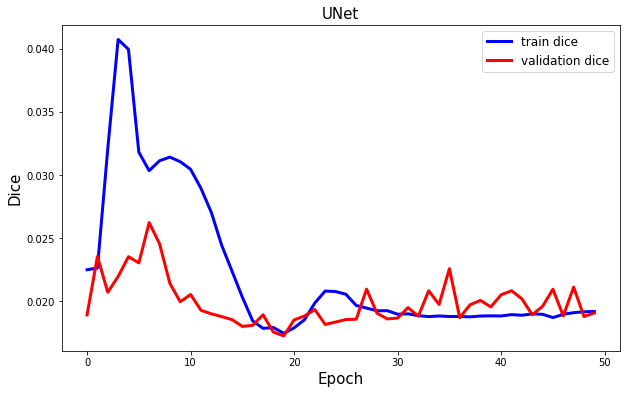

In [ ]:
def plot_model_history(model_name, train_history, val_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="b")
    plt.plot(x, val_history, label='validation dice', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Dice", fontsize=15)

    plt.show()
    
plot_model_history('UNet', train_history, val_history, num_epochs)

## 8. Prediction

In [ ]:
test_iou = compute_iou(model, test_dataloader)
print("Mean IoU: {:.3f}%".format(100*test_iou))

Mean IoU: 1.950%


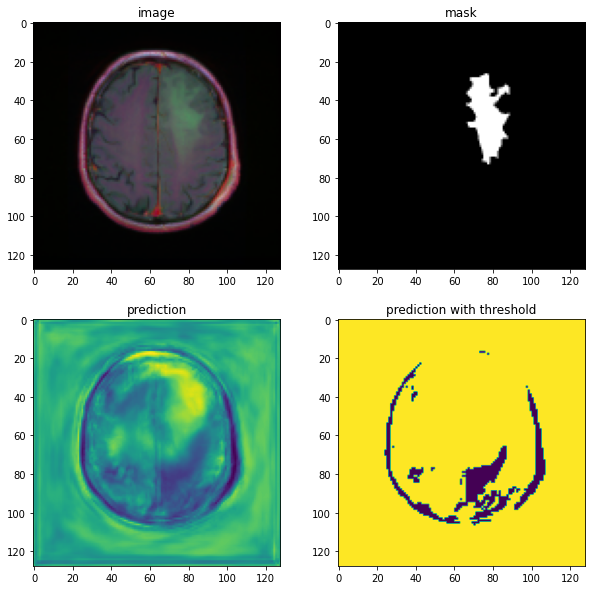

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred,score = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

In [ ]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(105).values

def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset
    
    Returns: list with images overlapping with predictions
    
    """
    prediction_overlap = []
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[0]),(128, 128))
        image =  image / 255.
        ground_truth = cv2.resize(cv2.imread(test_sample[1], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(prediction)
        prediction, score = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.
        prediction = prediction.astype("uint8")

        # overlap 
        original_img = cv2.resize(cv2.imread(test_sample[0]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
    
prediction_overlap_r = batch_preds_overlap(model, test_samples)

In [ ]:
pred_overlap_5x1_r = []
pred_overlap_5x3_r = []

for i in range(5, 105+5, 5):
    pred_overlap_5x1_r.append(np.hstack(np.array(prediction_overlap_r[i-5:i])))

for i in range(3, 21+3, 3):
    pred_overlap_5x3_r.append(np.vstack(pred_overlap_5x1_r[i-3:i]))

In [ ]:
def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.close()

title = "Predictions of UNet"

for num, batch in enumerate(pred_overlap_5x3_r):
    plot_plate_overlap(batch,title, num)

In [ ]:
from PIL import Image

def make_gif(title):
    base_name = "_".join(title.lower().split())

    base_len = len(base_name) 
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"

    img, *imgs = [Image.open(f) 
                  for f in sorted(glob.glob(fp_in), key=lambda x : int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)
    
    return fp_out

fn = make_gif(title)

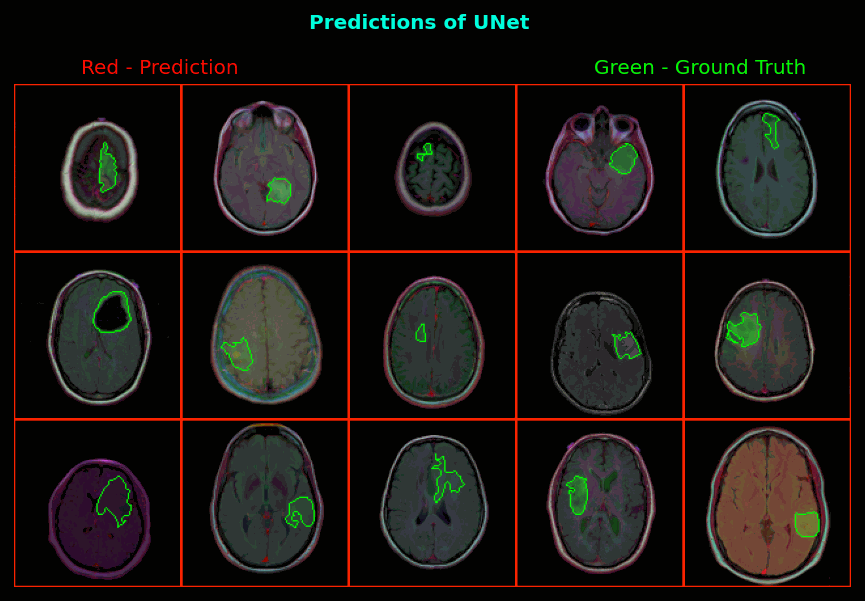

In [ ]:
from IPython.display import Image as Image_display
with open(fn,'rb') as f:
    display(Image_display(data=f.read(), format='png'))

In [ ]:
torch.save(model.state_dict(), 'unet-model.pt') 

### References
1: https://www.kaggle.com/bonhart/brain-mri-data-visualization-unet-fpn<br>
2: https://github.com/milesial/Pytorch-UNet<br>
3: https://arxiv.org/pdf/1505.04597v1.pdf